# **Assignment 3: Graph Neural Networks for Molecules**
Johan Rytved

---
In this assigment i will train a Graph Convolutional Neural Network (GCN) on the ESOL-dataset to predict the solubility of small molecules. In the first part i will go through some theory and the mathematics of the graph convolutional layer. I will then do train-test-splitting, train the model and evaluate the performance of the model on the test and validation sets. After i will look at how the error is correlating with the distribution of solubility levels of molecules in the training set, and how the model metrics vary due to the randomness of the train test split. Finally will compare the metric of the GCN to the dense neural network trained on morgan fingerprints, that we did in the last assignment.

I have chosen to use **PyTorch** rather than DeepChem for the GCN. This is mainly because i wanted to try and code the model from scratch at first so i could get a better understand of the mathematics of the GCN-layer, and it seems like PyTorch is the easiest library to make custom layers with. Also this gives me complete control over how to featurize the molecules, and i thought it would be fun to get better experience with RDKit and trying to come up with some clever ways to calculate atom-level features. I do however also train a DeepChem GCN-model to compare its performance with mine.

The assignment ended up being quite long and there is a lot of code. But i tried to organize the notebook so you don't have to read all the code but can just look at the figures. I put in the title of all sections that just have code, so you can expand them if you want to see it, and otherwise you can just skip it.


## **Imports (Including loading of the ESOL-dataset)**

In [ ]:
!pip install rdkit torch_geometric deepchem

  Using cached rdkit-2023.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)
  Using cached deepchem-2.7.1-py3-none-any.whl (693 kB)


In [ ]:
import numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt, rdkit, re, math, networkx as nx, deepchem as dc
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs, AllChem
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges
from tensorflow import keras
from collections import Counter

import torch
import torch.nn as nn
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GATConv, GINConv, ChebConv
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.utils import to_networkx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if runtime type is set to use GPU.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
data = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv")

## **Utility Functions, Plotting Functions etc...**

In [ ]:
def MolsToPlot(mols: list[rdkit.Chem.Mol], n_per_row: int, title:str, toplabels: list = None, botlabels: list = None):

  N = len(mols)
  M = math.ceil(N / n_per_row)

  fig, ax = plt.subplots(M, n_per_row, figsize = (10,10))
  fig.suptitle(title, fontweight = "bold", fontsize = 18)

  k = 0

  for i in range(M):
    for j in range(n_per_row):

      if k >= len(mols):
        break
      else:
        ax[i][j].imshow(Chem.Draw.MolToImage(mols[k]))
        ax[i][j].axis("off")

        if toplabels is not None:
          ax[i][j].set_title(toplabels[k], fontsize = 12)

        if botlabels is not None:

          xlim = ax[i][j].get_xlim()
          ylim = ax[i][j].get_ylim()

          # Calculate the center coordinates
          x_center = (xlim[1] - xlim[0]) / 2 + xlim[0]
          y_center = (ylim[1] - ylim[0]) / 2 + ylim[0]
          ax[i][j].text(x_center, ylim[0]+20, botlabels[k], ha='center', va='center', fontsize = 8)

        k += 1


  plt.tight_layout(pad = 3)

In [ ]:
def pad_array(x: np.ndarray,
              shape,
              fill: float = 0.0,
              both: bool = False) -> np.ndarray:
    """
    Pad an array with a fill value.

    Parameters
    ----------
    x: np.ndarray
        A numpy array.
    shape: Tuple or int
        Desired shape. If int, all dimensions are padded to that size.
    fill: float, optional (default 0.0)
        The padded value.
    both: bool, optional (default False)
        If True, split the padding on both sides of each axis. If False,
        padding is applied to the end of each axis.

    Returns
    -------
    np.ndarray
        A padded numpy array
    """
    x = np.asarray(x)
    if not isinstance(shape, tuple):
        shape = tuple(shape for _ in range(x.ndim))
    pad = []
    for i in range(x.ndim):
        diff = shape[i] - x.shape[i]
        assert diff >= 0
        if both:
            a, b = divmod(diff, 2)
            b += a
            pad.append((a, b))
        else:
            pad.append((0, diff))
    pad = tuple(pad)  # type: ignore
    x = np.pad(x, pad, mode='constant', constant_values=fill)
    return x

In [ ]:
def DrawIdx(mol: str | rdkit.Chem.rdchem.Mol, addHs = True, imsize = (500,500)):
  """
  TAKES: rdkit.mol object or smiles. If SMILES, then converts to rdkit.mol. Adds hydrogens if addHs = True.
  RETURNS: A PIL.PngImagePlugin.PngImageFile of molecule drawn with atom indexes labelled.
  """
  if type(mol) == str:
    mol = Chem.MolFromSmiles(mol)
  if addHs:
    mol = Chem.AddHs(mol)

  drawopts = Chem.Draw.MolDrawOptions()
  drawopts.addAtomIndices = True
  return Chem.Draw.MolToImage(mol, options = drawopts, size = imsize)

In [ ]:
def makefig1():
  fig, ax = plt.subplot_mosaic("ABC", figsize = (15,5))

  ax["A"].set_title("A) Aspirin", fontweight = "bold")
  ax["A"].imshow(DrawIdx(mol))
  ax["A"].axis("off")

  ax["B"].set_title("B) Adjacency Matrix", fontweight = "bold")
  ax["B"].imshow(A, cmap = "plasma", aspect = "auto")
  ax["B"].set_xlabel("Node Idx.")
  ax["B"].set_ylabel("Node Idx.")
  ax["B"].set_xticks(range(21))
  ax["B"].set_yticks(range(21))
  ax["B"].set_xticklabels(range(21), rotation = 90)


  ax["C"].set_title("C) Node Feature Matrix", fontweight = "bold")
  ax["C"].imshow(X, cmap = "plasma", aspect='auto')
  ax["C"].set_ylabel("Node Idx.")
  ax["C"].set_xticks(range(6))
  ax["C"].set_yticks(range(21))
  ax["C"].set_xticklabels(["H","C", "N", "O", "Aromaticity", "Degree"], rotation = 90)
  ax["C"].set_xlabel("Feature")

  fig.suptitle("Figure 1: Aspirin, it's adjacency matrix and node feature matrix.", fontweight = "bold", fontsize = 22)

  plt.tight_layout(pad=2)

In [ ]:
def makefig2():
  fig, ax = plt.subplots(2, 4, figsize = (15,10))
  plt.suptitle("Fig. 2: Matrices involved in the GCN-layer", fontsize = 16, fontweight = "bold")
  ax[0][0].imshow(A, cmap = "plasma", aspect = "auto")
  ax[0][0].set_title("Adjacency Matrix, $A$")
  ax[0][0].set_xlabel("Node Idx.")
  ax[0][0].set_ylabel("Node Idx.")


  ax[0][1].imshow(GC.adj_normalized, cmap = "plasma", aspect = "auto")
  ax[0][1].set_xlabel("Node Idx.")
  ax[0][1].set_ylabel("Node Idx.")
  ax[0][1].set_title("Adjacency Matrix Normalized, $\hat A$")

  ax[0][2].imshow(X, cmap = "plasma", aspect = "auto")
  ax[0][2].set_xlabel("Feature")
  ax[0][2].set_ylabel("Node Idx.")
  ax[0][2].set_title("Node Feature Matrix, $X$")

  ax[0][3].imshow(GC.W, cmap = "plasma", aspect = "auto")
  ax[0][3].set_title("Array of Trainable Weights, $W$")

  ax[1][0].imshow(GC.Z, cmap = "plasma", aspect = "auto")
  ax[1][0].set_title("$Z=\hat A \cdot X$")
  ax[1][1].imshow(GC.Zp, cmap = "plasma", aspect = "auto")
  ax[1][1].set_title("$Z' = Z \cdot W$")
  ax[1][2].imshow(H1, cmap = "plasma", aspect = "auto")
  ax[1][2].set_title("$H=\sigma(Z')$")
  ax[1][3].imshow(H1.sum(axis=0, keepdims=True), cmap = "plasma")
  ax[1][3].set_title("Molecular Embedding (H summed along axis 0)")
  ax[1][3].set_yticks([])


  plt.tight_layout(pad=2)

In [ ]:
def makefig3():
  fig, ax = plt.subplot_mosaic("AB;CC", figsize = (20, 10))
  ax["A"].imshow(DrawIdx(metformin_mol, imsize = (1800,800)))
  ax["A"].axis("off")
  ax["A"].set_title("Metformin")

  ax["B"].set_title("Graph Representation of Metformin")

  G = to_networkx(exdata)
  ax["B"].axis('off')
  nx.draw_networkx(G,
                  pos=nx.spring_layout(G, seed=0),
                  with_labels=True,
                  node_size=800,
                  cmap="hsv",
                  width=0.8,
                  edge_color="grey",
                  font_size=14,
                  ax = ax["B"]
                  )

  ax["C"].imshow(metformin_edge_idx, cmap = "plasma")
  ax["C"].set_xticks([])
  ax["C"].set_yticks([])
  ax["C"].set_title("Edge-Index for Metformin")

  for row in range(metformin_edge_idx.shape[0]):
    for column in range(metformin_edge_idx.shape[1]):
      ax["C"].text(column, row, metformin_edge_idx[row][column].item(), va = "center", ha = "center", color  ="white")


  ax["C"].annotate('Edges (Direction 1)', xy=(0.19,0.2), xytext=(0.19,0.2), xycoords='subfigure fraction',
              fontsize=9, ha='center', va='bottom',
              bbox=dict(boxstyle='square', fc='white', color='k'),
              arrowprops=dict(arrowstyle='-[, widthB=23.5, lengthB=1.5', lw=2.0, color='k'))

  ax["C"].annotate('Edges (Direction 2)', xy=(0.19*2.65,0.2), xytext=(0.19*2.65,0.2), xycoords='subfigure fraction',
              fontsize=9, ha='center', va='bottom',
              bbox=dict(boxstyle='square', fc='white', color='k'),
              arrowprops=dict(arrowstyle='-[, widthB=23.5, lengthB=1.5', lw=2.0, color='k'))

  ax["C"].annotate('Edges (Self Directed)', xy=(0.8175, 0.2), xytext=(0.8175,0.2), xycoords='subfigure fraction',
              fontsize=9, ha='center', va='bottom',
              bbox=dict(boxstyle='square', fc='white', color='k'),
              arrowprops=dict(arrowstyle='-[, widthB=23, lengthB=1.5', lw=2.0, color='k'))

  plt.suptitle("Fig. 3: Metformin and edge-index representation of its connectivity", fontweight = "bold", fontsize = 18)

  plt.tight_layout(pad = 4)

In [ ]:
def makefig4():
  fig, ax = plt.subplots(1,4, figsize = (15,5))
  ax[0].set_title(f"Pred. On Train Set. MSE: {torch_train_mse}")
  ax[0].scatter(torch_train_preds, y_train, alpha = .5, label = "Predictions")
  ax[0].plot(y_train, y_train, color = "black", label = "Ground Truth / Label")

  ax[1].set_title(f"Pred. On Test Set. MSE: {torch_test_mse}")
  ax[1].scatter(torch_test_preds, y_test, alpha = .5, label = "Predictions")
  ax[1].plot(y_test, y_test, color = "black", label = "Ground Truth / Label")

  ax[2].set_title(f"Pred. On Validation Set. MSE: {torch_val_mse}")
  ax[2].scatter(torch_val_preds, y_val, alpha = .5, label = "Predictions")
  ax[2].plot(y_val, y_val, color = "black", label = "Ground Truth / Label")

  ax[3].set_title(f"Null Model. MSE: {null_mse}")
  ax[3].plot(y_train, y_train, color = "black", label = "Ground Truth / Label")
  ax[3].scatter(std_vec, y_train, alpha = .5, label = "Predictions")

  for axis in [0,1,2,3]:
    ax[axis].set_xlabel("$y$")
    ax[axis].set_ylabel("$\hat y$")
    ax[axis].legend()
    ax[axis].set_xlim(-12,2)
    ax[axis].set_ylim(-12,2)

  fig.suptitle("Fig. 4: PyTorch GCNConv Performance: Predictions against Labels", fontweight = "bold", fontsize = 18)
  plt.tight_layout(pad=2)

In [ ]:
def makefig5():
  fig, ax = plt.subplots(figsize = (10,3))
  ax.plot(dc_train_losses, color = "red", label = "Training Loss")
  ax.plot(dc_valid_losses, color = "green", label = "Validation Loss")
  ax.set_ylim(0,5)
  fig.suptitle(f"Fig. 5: DeepChem GraphConv MSE over epochs", fontweight = "bold", fontsize = 18)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("MSE")
  plt.legend()
  plt.tight_layout()

In [ ]:
def makefig6():

  fig, ax = plt.subplots(1,4, figsize = (15,5))
  ax[0].set_title(f"Pred. On Train Set. MSE: {round(dc_train_mse, 2)}")
  ax[0].scatter(dc_train_preds, dc_y_train, alpha = .5, label = "Predictions")
  ax[0].plot(dc_y_train, dc_y_train, color = "black", label = "Ground Truth / Label")
  ax[0].set_xlabel("$y$")
  ax[0].set_ylabel("$\hat y$")
  ax[0].legend()

  ax[1].set_title(f"Pred. On Test Set. MSE: {round(dc_test_mse, 2)}")
  ax[1].scatter(dc_test_preds, dc_y_test, alpha = .5, label = "Predictions")
  ax[1].plot(dc_y_test, dc_y_test, color = "black", label = "Ground Truth / Label")
  ax[1].set_xlabel("$y$")
  ax[1].set_ylabel("$\hat y$")
  ax[1].legend()

  ax[2].set_title(f"Pred. On Validation Set. MSE: {round(dc_valid_mse, 2)}")
  ax[2].scatter(dc_valid_preds, dc_y_valid, alpha = .5, label = "Predictions")
  ax[2].plot(dc_y_valid, dc_y_valid, color = "black", label = "Ground Truth / Label")
  ax[2].set_xlabel("$y$")
  ax[2].set_ylabel("$\hat y$")
  ax[2].legend()

  ax[3].set_title(f"Null Model. MSE: {null_mse}")
  ax[3].plot(dc_y_train, dc_y_train, color = "black", label = "Ground Truth / Label")
  ax[3].scatter(std_vec, dc_y_train, alpha = .5, label = "Predictions")
  ax[3].set_xlabel("$y$")
  ax[3].set_ylabel("$\hat y$")
  ax[3].legend()


  fig.suptitle("Fig. 6: DeepChem GraphConv Performance: Predictions against Labels", fontweight = "bold", fontsize = 18)
  plt.tight_layout(pad=2)

In [ ]:
def makefig7():
  fig, ax  = plt.subplots(figsize = (15,5))
  ax.plot(train_err, color = "blue", label = "Train Error")
  ax.plot(test_err, color = "green", label = "Test Error")
  ax.plot(val_err, color = "red", label = "Validation Error")
  ax.legend()

  ax.set_xticks(range(10))
  ax.set_xticklabels(range(1, 11))
  ax.set_ylabel("MSE")
  ax.set_xlabel("Round of Train-Test-Val Split")
  fig.suptitle("Fig. 7: Train, Test and Validation Error Over 10 Different Random Train-Test-Val Splits", fontweight = "bold", fontsize = 22)
  ax.set_title(f"Mean Train MSE: {np.mean(train_err).round(2)} | Mean Test MSE: {np.mean(test_err).round(2)}  Mean Val MSE: {np.mean(val_err).round(2)}")
  fig.tight_layout(pad=2)

In [ ]:
def makefig8():
  fig, ax = plt.subplots(2,3, figsize = (15,5))

  plot_labels = ("Train", "Test", "Val")
  plot_colors = ("Blue", "Orange", "Green")

  ax[0][0].set_title("Distribution of Solubility Values", fontweight = "bold", fontsize = 9)
  ax[0][0].hist(labels, label = plot_labels, color = plot_colors)
  ax[0][0].legend()

  ax[0][1].set_title("Distribution of Error Values", fontweight = "bold", fontsize = 9)
  ax[0][1].hist(errors, label = plot_labels, color = plot_colors)
  ax[0][1].legend()

  ax[0][2].set_title("Distribution of Absolute Error Values", fontweight = "bold", fontsize = 9)
  ax[0][2].hist(abs_errors, label = plot_labels, color = plot_colors)
  ax[0][2].legend()

  for i, axis in enumerate([ax[1][0], ax[1][1], ax[1][2]]):
    axis.scatter(labels[i], abs_errors[i], color = plot_colors[i])
    axis.set_xlabel("log(s)")
    axis.set_ylabel("Absolute Error")
    axis.set_title(f"{plot_labels[i]} Absolute Error vs Labels")
    mean = labels[i].mean()
    axis.axvline(mean, color = "black", label = "Mean log(s)")
    axis.legend(loc = 1)

  plt.suptitle("Fig. 8: Correlation Between Solubility And Error", fontweight = "bold", fontsize = 18)
  plt.tight_layout(pad=2)

In [ ]:
def makefig9():
  fig, ax = plt.subplots(1, 2, figsize = (20,7))
  x = np.arange(len(frags))

  ### FRAGMENT PLOT
  ax[0].plot(x, large_error_frag_array_sum, color = "red", label = "Large Error Molecules")
  ax[0].plot(x, low_error_frag_array_sum, color = "green", label = "Low Error Molecules")

  ax[0].scatter(x, large_error_frag_array_sum, color = "red")
  ax[0].scatter(x, low_error_frag_array_sum, color = "green")

  ax[0].legend()
  ax[0].set_xticks(x)
  ax[0].set_xticklabels(group_names, rotation = 90)
  ax[0].set_title("Count of Selected Fragments")
  ax[0].set_xlabel("Fragment")
  ax[0].set_ylabel("Count (Unique)")

  ### SIZE PLOT
  ax[1].hist(large_error_n_atoms, color = "red", label = "Large Error Molecules")
  ax[1].hist(low_error_n_atoms, color = "green", label = "Low Error Molecules")
  ax[1].legend()
  ax[1].set_xlabel("Number of Atoms in Molecule")
  ax[1].set_ylabel("Sum of Count of Fragment")
  ax[1].set_title("Molecule Size (Total No. Atoms) ")


  fig.suptitle("Fig. 9: Comparison of Chemistry of Low and High Error Molecules", fontweight = "bold", fontsize = 18)
  plt.tight_layout()

In [ ]:
def makefig10():
  _y = data["measured log solubility in mols per litre"].values
  fig, ax = plt.subplots(figsize = (15,5))
  ax.hist(_y[lowest_errors_idx], alpha = .5, color = "green", bins = 10, label = "Low Error Molecules")
  ax.hist(_y[largest_errors_idx], alpha = .5, color = "red", bins = 10, label = "Large Error Molecules")
  ax.legend()
  ax.set_xlabel("Solubility")
  ax.set_ylabel("Count")

  fig.suptitle("Fig. 10: Distribution of Solubilities of High And Low Error Molecules (Avg. over 100 Train-Test Splits)", fontweight = "bold", fontsize = 18)
  fig.tight_layout()

## **Theory**

#### **Data structures to represent graphs - The adjacency matrix $A$ and the node feature matrix, $X$.**
To start out, I'll define some terms to describe the datastructures we will use when working with convolutions on graphs. First, a graph $G=(V,E)$ consists of a set of vertices/nodes $V$ and a set of edges $E$ that connects them. One node can have many edges or a few edges. The number of edges associated with one node is called the degree. An edge can also be either be directed or undirected. Finally, an edge can also be self-directed, so it arises from the same node that it ends at.

The graph as whole can be cyclic or acyclic. For molecules our graphs will have to be cyclic. At least if we dont want to exclude every single molecule that has rings, which is quite a lot. The edges will be undirected, since there is no concept of direction in a chemical bond.

**The Adjacency Matrix**

To represent the connectivity of a graph, we can create the adjacency matrix $A$. $A$ is an $n \cdot n$-matrix with $n$ being the number of nodes in the graph. In the adjacency matrix, the element $A_{i,j}$ is 1 if node with index $i$ is connected to node with index $j$. Otherwise it is $0$.

**The Node Feature Matrix**

Each node may have a feature vector of size $m$. This gives our node feature matrix the shape $n \cdot m$ with $n$ again being the number of nodes and $m$ being the number of features. Since each node represents an atom there are many possibilities for features. It could for example be the atom type, aromaticity, hybridization, valence, formal-charge etc.

So these were just some examples, and obviously you can imagine many different features we could use, as long as it is a property of the atom (atom-level). I will get more into detail with featurizing the molecule later on.

Below i will take the small molecule drug Aspirin (acetylsalicylic acid) plot it's adjacency matrix and a simple feature vector for three features that are quickly computed with RDKit: atomic numbers (one-hot), aromaticity (binary) and degree (numeric).

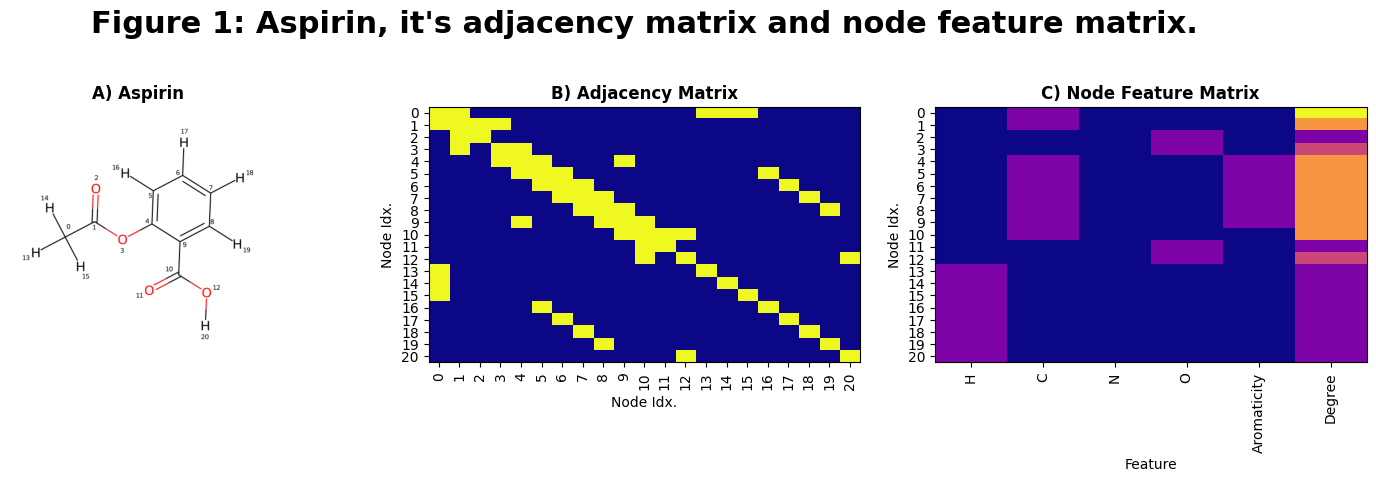

In [ ]:
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"                                                     # SMILES for Aspirin
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)                                                                   # Add hydrogen atoms explicitly

atoms = mol.GetAtoms()

A = Chem.GetAdjacencyMatrix(mol)                                                        # Create Adjacency (A) and Identity (I) Matrices
I = np.eye(len(atoms))
A = A + I                                                                               # Add A to I to create self-loops

atomic_num_list = []                                                                    # List to hold arrays of one-hot-encoded atomic numbers for each atom

oh_idx_dic = {1: 0, 6: 1, 7: 2, 8: 3}                                                   # Maps each atomic num to an index

for atom in atoms:
  atomic_nums = np.zeros(4)                                                             # Size 4 vec to one-hot encode atoms. We assume there are only H, C, N and O atoms in the molecule for now.
  an = atom.GetAtomicNum()                                                              # Get the atomic num for each atom, find the index that is to be set to 1 in the oh_idx_dic and set it.
  an_idx = oh_idx_dic[an]
  atomic_nums[an_idx] = 1
  atomic_num_list.append(atomic_nums)

atomic_nums = np.array(atomic_num_list)                                                 # Convert the list of arrays into a single array that holds all the one-hot encoded atomic num. vectors

aromatic = np.array([1 if atom.GetIsAromatic() else 0 for atom in atoms]).reshape(-1,1) # Compute aromaticity for all atoms. 1 if is aromatic, otherwise 0.
degrees = np.array([atom.GetDegree() for atom in atoms]).reshape(-1,1)                  # Compute the degree (no. of atoms bound to the atom).

X = np.hstack([atomic_nums, aromatic, degrees])                                         # Stack all the features so far together into a single matrix X.

makefig1()

#### **The Graph Convolutional Neural Network**

In a graph convolutional neural network, the feature vector for each node are at each convolution updated by performing an aggregation of the feature vectors belonging to the neighbors of said node. The aggregation could for example be taking the mean of the features. If we look back at the Aspirin molecule, we see that node $1$ is neighbored by node $2$, $0$ and $3$. So after one convolution, the feature vector $x_1$ for node $1$ will be the mean of the feature vectors $x_2, x_0$ and $x_{3}$ as well as the feature vector of the node ($x_0$) itself. This also explains why we needed to add the the identity matrix, $I$ to our adjacency matrix, $A$. The identity matrix is simply a matrix with ones along the diagonals and zeros everywhere else. In other words $I_{i,j}$ is 1 if $i=j$ and otherwise it is zero. This corresponds to adding a self-directed edge for all nodes. If we didnt, then the node that the convolution operation is applied to does not have an edge directed to itself, and it would not have it's own feature vector take part in the aggregation when doing the convolution.

This aggregation procedure is often called message passing, as each node passes a message to it's neighbors (and itself), with the message being it's own feature vector.

It also here becomes apparent what the similarity between a regular CNN that operates on regular matrices, and the GCN that operates on graph. In the CNN a sliding window or 'filter' passes over the matrix one element at a time, aggregating features to create a new representation. Likewise the GCN operates on one node at a time (one atom in this case) and updates that atoms feature vector, by aggregating the feature vectors of it's own neighbors, leading to a new representation.

By adjusting the amount of convolutions we make, we determine how 'far' each message is passed throughout the graph. If we make 1 convolution, the message from node $n_1$ is only passed to it's neighbours. If we do 2 convolutions then the previously made aggregations are now passed forward, so some information from each node is now passed to nodes that are two 'hops' away.

So far we have no trainable parameters and therefore no foundation for a machine learning model. To introduce this, each convolutional layer gets a weight matrix that is multiplied on the aggregated node features. This will allow the model to learn to extract the most important features after each convolution.

#### **The Math**
The equation for a graph convolutional layer is a function of the feature matrix $X$ and adjacency matrix $A$.

$$H_1=f(X,A)=\sigma(D^{-1/2}(A+I)D^{-1/2}XW_1)$$

Here we introduce $I$ that is the identity matrix and has the shape $n \cdot n$ with $n$ being the number of nodes. The identity matrix has ones along the diagonal and 0's everywhere else. The reason for adding the identity matrix to the adjacency is to add self-loops. by adding a 1 at all elements in $A_{i,j}$ where $i=j$ we create a self directed edge for all nodes.

We also introduce the normalized degree matrix $D^{1/2}$. The degree matrix is a a diagonal matrix like $I$ where each element $i,i$ has the number of neighbors for node $i$. This can be calculated by summing along one of the axises in $(A+I)$ and then casting the resulting vector along the diagonal of matrix with shape $n \cdot n$.

The degree matrix, $D$, is normalized by taking the reciprocal of the square root of each element in $D$. This serves to normalize the impact of the feature vectors on the message passing, to the degree of each node. We can imagine that a node with many neighbors (high degree) will have a high influence of the aggregated features of other nodes in the network, while a node with few neighbors (low degree) will have very little influence, if this normalization was not performed. The normalization combats this by essentially making the signal coming from nodes with many neighbors smaller.

Finally, $\sigma$ denotes a non-linear activation functions that we apply to the embedding output from the convolutional layer.

We called the output of the first convolutional layer $H_1$ to do several convolutions we simply stack the layers in the manner:

$$H_1 = f(X,A)$$
$$H_2 = f(H_1,A)$$
$$H_3 = f(H_2,A)$$

Each layer $L$ has it's own trainable weight matrix $W_L$.

Below, i will use this math to build the convolutional layer class from scratch in a PyTorch-class, before moving onto using PyTorch's built in convolutional layer classes.

In [ ]:
class GraphConv():

  def __init__(self):
    pass

  def make_degree(self, A):
    degree = np.sum(A, axis = -1)                             # Make a degree vector by summing along the last axis.
    diag_degree = np.diag(degree)                             # Cast the degree along the diagonal
    diag_sqrt = np.sqrt(diag_degree)                          # Square root it
    diag_sqrt_inv = np.linalg.inv(diag_sqrt)                  # And take the reciprocal/inverse
    return diag_sqrt_inv

  def relu(self, X):
    return np.maximum(0, X)

  def init_weights(self):
    self.W = np.random.rand(self.n_features, self.out_dim)    # Init. a random array of weights

  def forward(self, X, A, out_dim):
    self.out_dim = out_dim
    self.n_features = X.shape[1]
    self.init_weights()

    D = self.make_degree(A)                                    # Initialize the normalized degree matrix
    I = np.eye(A.shape[0])                                     # Initialize the identity matrix
    Ap = A + I                                                 # Add the identity matrix to the adjacency matrix.
    self.adj_normalized = D @ Ap @ D                           # Normalize the adjacency matrix using the degree matrix.
    self.Z = (self.adj_normalized @ X)                         # Do the convolutional operation
    self.Zp = self.Z @ self.W                                  # Apply weights
    H = self.relu(self.Zp)                                     # Apply non-linear activation function

    return H

In [ ]:
GC = GraphConv()
H1 = GC.forward(X, A, out_dim = 5)

Using this class, i will make a visual heatmap representation of  the matrices that are involved in the GCN-layer so it is easy to see what is going on in the layer. In the top row of fig. 2 i show the 'raw' adjacency matrix, then the normalized adjacency matrix $\hat A$. $\hat A$ corresponds to $D^{-1/2}(A+I)D^{-1/2}$ as seen in the original equation for the GCN. After that, we have the node feature matrix $X$ and the array of trainable weights $W$.

In the bottom row i show $Z$ that is the matrix multiplication of $\hat A$ and $X$, then $Z'$ that is just $Z$ multiplied by the weight matrix $W$, then $H$ that is just the activation function (ReLU) applied to $Z'$ and finally there is the actual molecular embedding we get by summing $H$ along the rows, collapsing all the features across the atoms into a single sum.




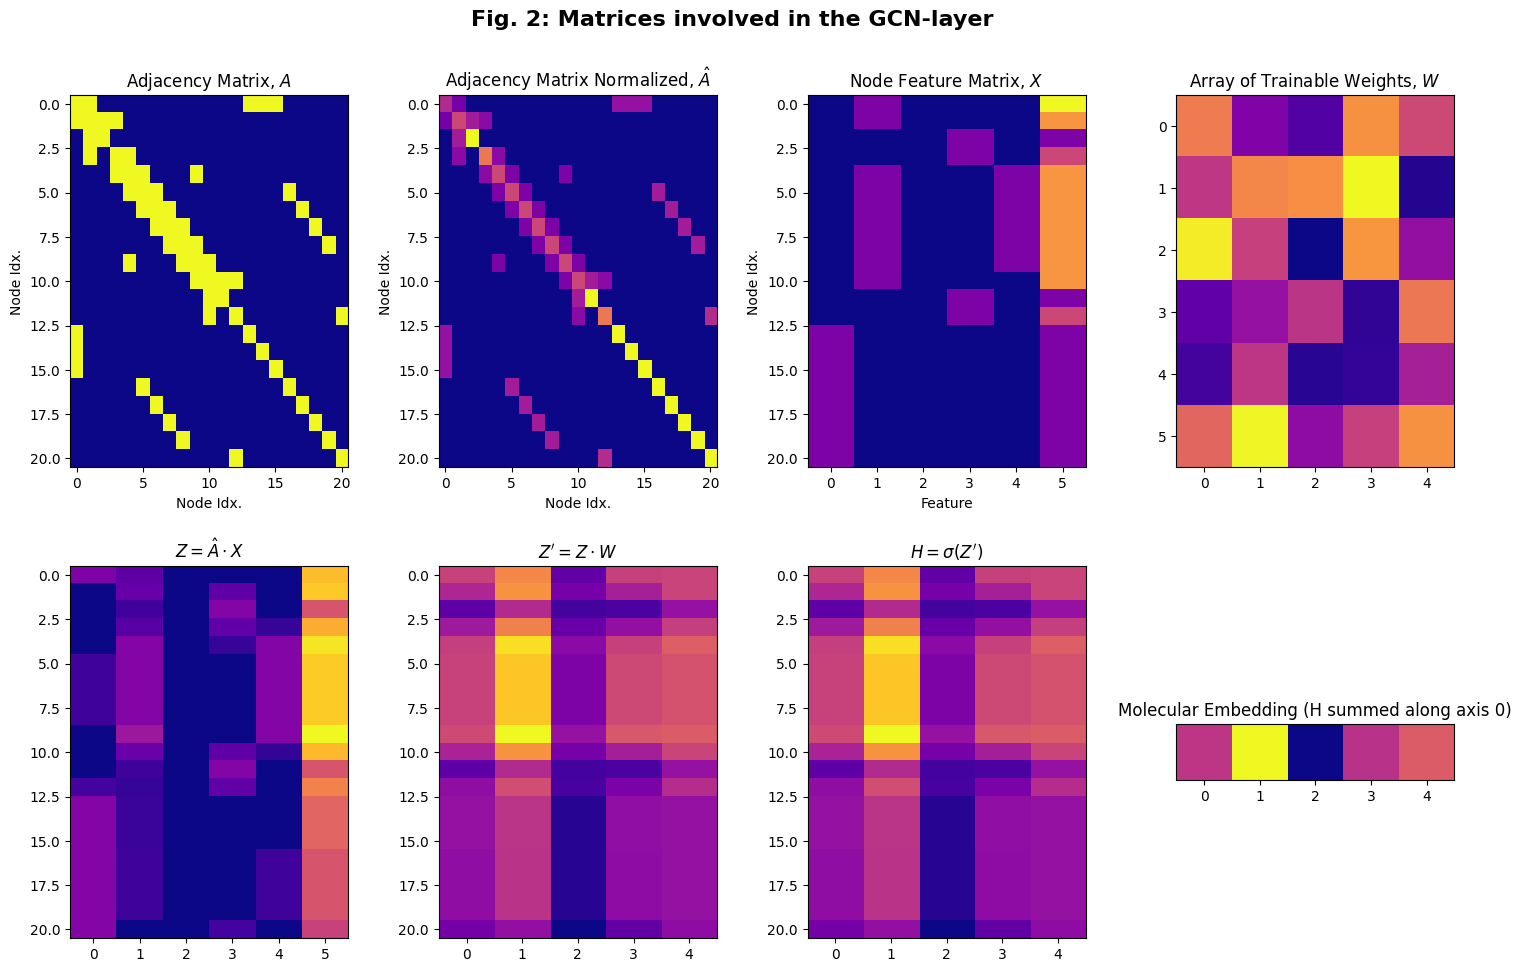

In [ ]:
makefig2()

#### **Normalization of $A$**
As mentioned, $A$ is normalized by matrix multiplication with the inverse of the square root of the degree matrix, $D$.

If we multiply the adjacency matrix $A$ by the inverse degree matrix $D$, then all elements take on the value $1 / d_{i,i}$. In other words, the adjacency matrix is now normalized to the sum of neighbors to $i$.

If we do the normalization proposed in the equation for the GCN, which is $D^{1/2}AD^{1/2}$, then all elements of $\hat A$, are $\hat A_{i,j}=\frac{1}{\sqrt{d_{i,i}d_{j,j}}}$. It is now apparent that adjacency matrix is now normalized to not only neighbors of the node $i$ but also the the neighbors of its neighbor, $j$. Again, it serves to decrease the weight of nodes with a large degree.

After a single convolution we will have a problem if we dont normalize $A$, because all the nodes with many neighbors have very high values after the neighbour-aggregation, while those with few neighbors have very low values. In such a case the 'signal' or the message coming from nodes with few neighbors will tend to drown, while the signal from nodes with many neighbors will have a huge influence.



#### **A few words on the output-dimension of the GCN-layer**
In Fig 2. i chose the first dimension of the array of trainable weights $W$, to be identical to the number of features, such that $Z = \hat A \cdot X$ would have the same dimension as the original node feature matrix. But it is indeed possible to make the first dimension of $W$ bigger (or smaller), such that $Z$ gets a different shape than $X$. You could argue that a bigger dimension of the weight array would allow more complex relationships in the data to be learned, because there are more weights that can be adjusted. So this is one example of a hyperparameter that we can tune later on when training the model.

#### **Creating the Molecule Embedding And Permutation Invariance**
If we go back to Fig. 2 and look at the final plotted matrix, it is the molecule embedding obtained by for example, summing, taking the mean or taking the max along the feature dimension of the output, which we called $H$. In this case it was a sum. This operation is very important. So why would we do that instead of just for example passing $H$ into a dense neural network, and predict some property (such as solubility) from it? The problem that arises has to do with the ordering of the nodes. The order of the nodes in the node feature matrix has no apparent meaning chemically. No matter how we shuffle them it would still represent the same molecule. But our machine learning model does not know this, and if we don't make a reduction to the molecular embedding, then supplying the model with nodes in two different orders, would give rise to two different predictions even though it's the same molecule. In that case our model would not be what is called permutation invariant.

By making an aggregation along the feature dimension (like we did when taking the sum), we make the network premutation invariant, because it doesn't matter how we shuffle the numbers along the feature dimension, their sum is still the same and so the molecular embedding is the same. Now we can pass this molecular embedding further into a dense neural network, without having any further problems in regards to the ordering of the nodes.

## **Atom-Level Featurization of RDKit Molecules**
With the knowledge of how graphs are described with a node-feature matrix and an adjacency matrix, i can write a class that will create meaningful node feature-matrices for any molecule. I will implement this in the class FeaturizeMol, that will let us pass some keywords corresponding to certain features we want, and then it returns a node feature matrix. Expand this section if you want to see the code.

Below are some large blocks of code that i've come up with to featurize the molecules. Basically all the code contributes to a single class called **FeaturizeMols** that is used to featurize the molecules. It is made so that you can pass a series of select keywords, like ex. 'aromaticity' or 'partial_charges' and then that atomic level feature will be encoded into the feature vector of the molecules passed to the class.

In [ ]:
def compute_interatomic_dist(conf):

  """
  Computes all interatomic distances for an RDKit-Conformer. This is used to calculate coulombic interactions in the simple_coulomb_matrix function.
  """

  n_atoms = conf.GetNumAtoms()

  coords = [
      conf.GetAtomPosition(i).__idiv__(0.52917721092) # Convert AtomPositions from Ångstrøm to Bohr
      for i in range(n_atoms)
    ]

  d = np.zeros((n_atoms, n_atoms), dtype=float)

  for i in range(n_atoms):
    for j in range(i):
      d[i, j] = coords[i].Distance(coords[j])
      d[j, i] = d[i, j]

  return d

def simple_coulomb_matrix(mol, max_atoms) -> np.ndarray:

  """
  Computes a 'simplified' version of a coulomb matrix that is stored as a vector.
  For every atoms, its coulombic interactions with all other atoms in the molecule are calculated
  and stored in a vector of size (number_of_atoms_in_mol). The vector is padded with zeros giving it a total size
  of the max atoms in a molecule across the whole dataset, to make sure all vectors are the same shape.
  """

  num_confs = len(mol.GetConformers())

  if num_confs == 0:
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())

  conformers = mol.GetConformers()
  first_conformer = conformers[0]

  n_atoms = mol.GetNumAtoms()

  z = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
  rval = []

  d = compute_interatomic_dist(first_conformer)

  m = np.outer(z, z) / d

  m[range(n_atoms), range(n_atoms)] = 0.5 * np.array(z)**2.4

  m = pad_array(m, (n_atoms, max_atoms))

  rval.append(m)

  cmat = np.asarray(rval)

  return cmat.squeeze()

In [ ]:
def atom_level_fingerprinter(mol, fp_size = 1024, useCounts = False):

  """
  An atomic level fingerprinter. Computes the morgan fingerprint of an atom.
  Each atom gets a vector of same size as fp. Then iterates over which fragment that triggered the flip of that on-bit.
  If the atom in question was part of the fragment that triggered the flip of the bit, then the bit is set to 1 in that atoms feature vector. Otherwise it is zeroed out.
  Can be set to use both normal and count-fingerprints.

  This one turned out to work pretty badly in practice. It gave an extremely low loss on the training set, but seemed to result in very heavy overfitting no matter what,
  giving a huge loss on training and validation set.

  """

  fp_gen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=fp_size)

  bitinfo = {}

  ao = AllChem.AdditionalOutput()
  ao.CollectBitInfoMap()

  if useCounts:
    fp_gen.GetCountFingerprint(mol, additionalOutput=ao)

  else:
    fp_gen.GetFingerprint(mol, additionalOutput=ao)

  n_atoms = mol.GetNumAtoms()
  feat_vec = np.zeros((n_atoms, fp_size))

  bi_map = ao.GetBitInfoMap()

  for i in bi_map.items():
    bit_index = i[0]
    atom_list = i[1]

    for tup in atom_list:
      atom_idx = tup[0]
      rad = tup[1]
      feat_vec[atom_idx][bit_index] = 1

  return feat_vec

In [ ]:
class FeaturizeMols():

  """
  Class to featurize RDKit Molecules into a matrix of one-hot-encoded vectors for each atom. Output has shape (n_atoms, n_features).
  Features passed in feature_list must be in: ["atom_type", "aromaticity", "degree", "hybridization", "n_hydrogens", "valence", "partial_charges", "coulomb_matrix", "bond_type", "formal_charge", "ecfp", "ecfp_count"]
  """

  hybridization_types =  {
  rdkit.Chem.rdchem.HybridizationType.UNSPECIFIED: 0,
  rdkit.Chem.rdchem.HybridizationType.S: 1,
  rdkit.Chem.rdchem.HybridizationType.SP: 2,
  rdkit.Chem.rdchem.HybridizationType.SP2: 3,
  rdkit.Chem.rdchem.HybridizationType.SP3: 4,
  rdkit.Chem.rdchem.HybridizationType.SP2D: 5,
  rdkit.Chem.rdchem.HybridizationType.SP3D: 6,
  rdkit.Chem.rdchem.HybridizationType.SP3D2: 7,
  rdkit.Chem.rdchem.HybridizationType.OTHER: 8
  }


  def __init__(self, feature_list: list, smiles: list | np.ndarray):
    self.feature_list = feature_list
    self.smiles = smiles
    self.map = self.map_atoms_to_dict()



  def map_atoms_to_dict(self):
    """Maps all atoms in a given list of SMILES to an integer. Prevents making a huge sparse matrix, which would occur when mapping directly to atomic numbers."""

    at_nums = {}

    max_atoms = 0

    i = 0

    for smile in self.smiles:
      mol = Chem.AddHs(Chem.MolFromSmiles(smile))
      n_atoms = mol.GetNumAtoms()

      if n_atoms > max_atoms:
        max_atoms = n_atoms


      atoms = mol.GetAtoms()

      for atom in atoms:
        at_num = atom.GetAtomicNum()
        if at_num not in at_nums:
          at_nums[at_num] = i
          i += 1

    self.max_unique_atoms = i

    self.max_atoms = max_atoms


    return at_nums


  def oh_encode_atoms(self):
    n_classes = len(self.map)

    arr = []

    for atom in self.atoms:
      vec = np.zeros(n_classes)
      an = atom.GetAtomicNum()
      idx = self.map[an]
      vec[idx] = 1
      arr.append(vec)

    return np.array(arr)

  def encode_aromaticity(self):
    return np.array([1 if atom.GetIsAromatic() else 0 for atom in self.atoms]).reshape(-1,1)

  def encode_degree(self):
    """One-hot encodes the degree in vector of size 8."""

    arr = []

    for atom in self.atoms:
      vec = np.zeros(8)
      idx = atom.GetDegree()  # The degree is simply the idx in the one-hot-encoded vector
      vec[idx] = 1
      arr.append(vec)

    return np.array(arr)

  def encode_gasteiger(self):
    """Computes Marsili-Gasteiger Partial Charges for all atoms"""
    ComputeGasteigerCharges(self.mol)
    self.atoms = self.mol.GetAtoms()
    return np.array([atom.GetDoubleProp('_GasteigerCharge') for atom in self.atoms]).reshape(-1,1)

  def encode_hybridization(self):

    arr = []

    for atom in self.atoms:
      vec = np.zeros(len(self.hybridization_types))
      idx = self.hybridization_types[atom.GetHybridization()]
      vec[idx] = 1
      arr.append(vec)

    return np.array(arr)


  def encode_coulomb_matrix(self):
    return simple_coulomb_matrix(self.mol, self.max_atoms)

  def encode_n_hs(self):
    """Encodes number of hydoogens"""

    arr = []

    for atom in self.atoms:
      vec = np.zeros(6)
      idx = atom.GetTotalNumHs(includeNeighbors=True)
      vec[idx] = 1
      arr.append(vec)

    return np.array(arr)

  def encode_ecfp(self, useCounts = False):
    return atom_level_fingerprinter(self.mol, useCounts = useCounts)

  def encode_bond_types(self):
    """Iterates over all bonds and gets begin and end atom idx as well as bond type."""

    map = {1.0: 0, 1.5: 1, 2: 2, 3: 3}

    arr = []

    for atom in self.atoms:

      vec = np.zeros(4)                       # We'll go with four bond types, see below

      for bond in self.bonds:
        if bond.GetBeginAtomIdx() == atom.GetIdx():
          bondtype = bond.GetBondTypeAsDouble() # 1: single, 1.5: aromatic, 2: double: 3: triple
          vec_idx = map[bondtype]
          vec[vec_idx] = 1

      arr.append(vec)

    return np.array(arr)

  def encode_valence(self):
    """One hot encodes valence"""

    arr = []

    for atom in self.atoms:
      vec = np.zeros(8)
      valence = atom.GetExplicitValence()
      vec[valence] = 1
      arr.append(vec)

    return np.array(arr)

  def encode_formal_charge(self):
    """One hot encodes the formal charge"""
    arr = []
    map = {0: 0, 1: 1, -1: 2}

    for atom in self.atoms:
      vec = np.zeros(3)
      formalCharge = atom.GetFormalCharge()
      idx = map[formalCharge]
      vec[idx] = 1
      arr.append(vec)

    return np.array(arr)

  def gen(self, smiles, apply_scaling = True):

    arr_list = []

    self.mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    self.atoms = self.mol.GetAtoms()
    self.bonds = self.mol.GetBonds()

    if "atom_type" in self.feature_list:
      arr_list.append(self.oh_encode_atoms())

    if "aromaticity" in self.feature_list:
      arr_list.append(self.encode_aromaticity())

    if "degree" in self.feature_list:
      arr_list.append(self.encode_degree())

    if "hybridization" in self.feature_list:
      arr_list.append(self.encode_hybridization())

    if "n_hydrogens" in self.feature_list:
      arr_list.append(self.encode_n_hs())

    if "partial_charges" in self.feature_list:
      arr_list.append(self.encode_gasteiger())

    if "coulomb_matrix" in self.feature_list:
      arr_list.append(self.encode_coulomb_matrix())

    if "ecfp" in self.feature_list:
      arr_list.append(self.encode_ecfp(useCounts=False))

    if "ecfp_count" in self.feature_list:
      arr_list.append(self.encode_ecfp(useCounts=True))

    if "bond_type" in self.feature_list:
      arr_list.append(self.encode_bond_types())

    if "valence" in self.feature_list:
      arr_list.append(self.encode_valence())

    if "formal_charge" in self.feature_list:
      arr_list.append(self.encode_formal_charge())


    return np.hstack(arr_list)

## **Some code needed to let PyTorch handle the data**
Here i go through the PyTorch specifics of creating data-structures that handle graphs. I show how the connectivity of graphs is represented with an edge-index matrix, as well as how a node-feature matrix generated with my FeaturizeMols class looks like. Expand if you want to see the code.

#### **A Function For Converting RDKit Molecules To an Edge Index Matrix**
Previously i showed that the connectivity of a graph could be represented by an adjacency matrix with the dimensions $(n_{atoms} \cdot n_{atoms})$. PyTorch prefers a slightly different data structure, which prevents the large sparse matrices that are inherent to an adjacency matrix. This datastructure has the shape $(2 \cdot n_{edges})$ and each column represents an edge, and contains the index of the node from which the edge emerges as the top row, and the index of the node to which the edge is directed as the bottom row. For example for a graph that just consists of two nodes, $1$ and $2$ with a single edge between them, the edge index matris $E$, would be represented as:

$E=\begin{bmatrix}
1 \\
2 \end{bmatrix}  $

We can quickly make a function that can generate such edge-index matrices for any molecule using the getBeginAtomIdx() and getEndAtomIdx() methods of RDKit. We'll call this function EdgeIndexFromSmiles.

In [ ]:
def EdgeIndexFromSmiles(smiles):

  """
  Computes the edge-index matrix to describe the connectivity of a molecule.
  Creates an edge in each direction for a bond in the molecule (to make the graph undirected)
  Also adds self-loops by adding self-directed edges for all nodes.

  INPUT: A SMILES string
  OUTPUT: A torch.tensor of type torch.long with the edge index.

  """

  mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
  N = mol.GetNumAtoms()
  atom_indexes = [atom.GetIdx() for atom in mol.GetAtoms()]

  # Making all non-self directed edges
  begAtoms = [i.GetBeginAtomIdx()for i in mol.GetBonds()]
  endAtoms = [i.GetEndAtomIdx()for i in mol.GetBonds()]

  # Making all edges non-directed (edges go both ways between any two nodes), and also adding self-directed edges
  topRow = begAtoms + endAtoms + atom_indexes
  botRow = endAtoms + begAtoms + atom_indexes

  edge_index = torch.tensor([topRow, botRow], dtype=torch.long)

  return edge_index

#### **A function for creating PyTorch graph datastructures**
PyTorch needs a special class to take care of data objects. They are basically just a wrapper to hold X-values (node features), edge-indexes (to represent connectivity) and y-values.

In [ ]:
def CreatePYGData(node_feature_matrix, edge_index_matrix, y, edge_feature_matrix = None):

  """
  Creates a PyTorch Geometric (PYG) DataObject from a node-feature matrix and an edge_index_matrix.
  Also has the possibility to add an edge-feature matrix if edge-features are to be included. This is not relevant for GCNConv.
  """

  n_nodes = node_feature_matrix.shape[0]

  node_feature_matrix = torch.tensor(node_feature_matrix, dtype = torch.float32)  # Convert node features to a PyTorch-tensor.
  y = np.array(y)
  y = y[..., np.newaxis, np.newaxis]                                              # Add Batch Axis to Y. Prerequisite for doing batching.
  y = torch.tensor(y, dtype = torch.float32)                                      # Convert y to a PyTorch-tensor.

  if edge_feature_matrix is not None:
    data = Data(x=node_feature_matrix, edge_index = edge_index_matrix, edge_attr = edge_feature_matrix, y = y, num_nodes = n_nodes)
  else:
    data = Data(x=node_feature_matrix, edge_index = edge_index_matrix, y = y, num_nodes = n_nodes)

  return data

### **An example of an edge-index matrix and a node-feature matrix**
An example of how i use the functions i have created to create the datastructures is given below, for the antidiabetic drug metformin. You can here see what the edge-index-matrix and graph-representation looks like. I also show the generated node-feature matrix. Notice that most entries are one-hot-encoded (yellow squares) and only one column is numerical (the partial charges). The partial charges will be standard scaled (normalized) across the whole dataset before training, as their magnitude are different from the rest of data.

In [ ]:
featurizer = FeaturizeMols(feature_list = ["atom_type", "aromaticity", "degree", "hybridization", "n_hydrogens", "bond_type", "partial_charges", "valence", "formal_charge"], smiles = data.smiles.values)
metformin = "CN(C)C(=N)N=C(N)N"                                                     # SMILES string for Metformin
metformin_mol = Chem.AddHs(Chem.MolFromSmiles(metformin))
metformin_node_features = featurizer.gen(metformin)                                 # Make the node-feature matrix (X)
metformin_edge_idx = EdgeIndexFromSmiles(metformin)                                 # Make the edge-index matrix
exdata = CreatePYGData(metformin_node_features, metformin_edge_idx, np.array(10))   # Generate the PYG-data object
exdata, exdata.is_directed(), exdata.has_self_loops()                               # Using PYG-methods to check that: 1) The graph is undirected and 2) the data has self-loops

(Data(x=[20, 50], edge_index=[2, 58], y=[1, 1], num_nodes=20), False, True)

Text(0.5, 1.0, 'Extra Fig: Node Feature Matrix for Metformin')

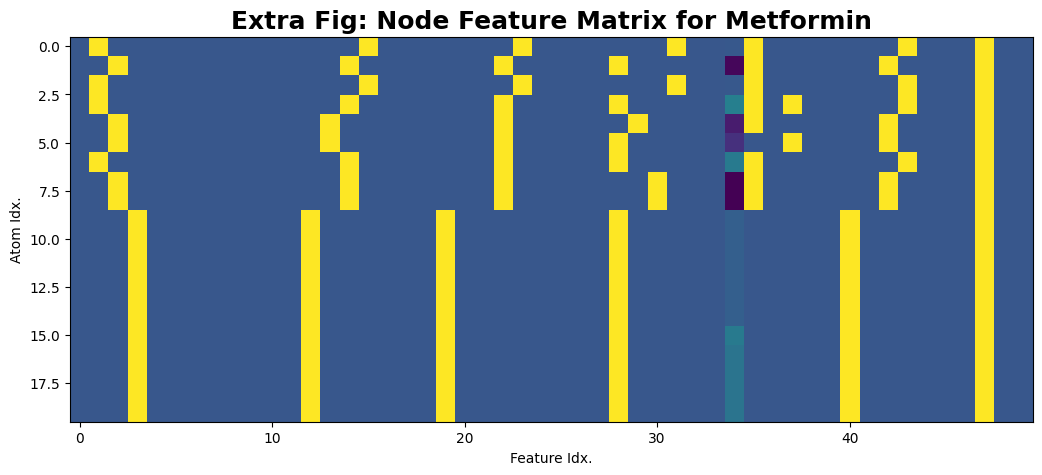

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax.imshow(metformin_node_features)
ax.set_ylabel("Atom Idx.")
ax.set_xlabel("Feature Idx.")
ax.set_title("Extra Fig: Node Feature Matrix for Metformin", fontweight = "bold", fontsize = 18)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


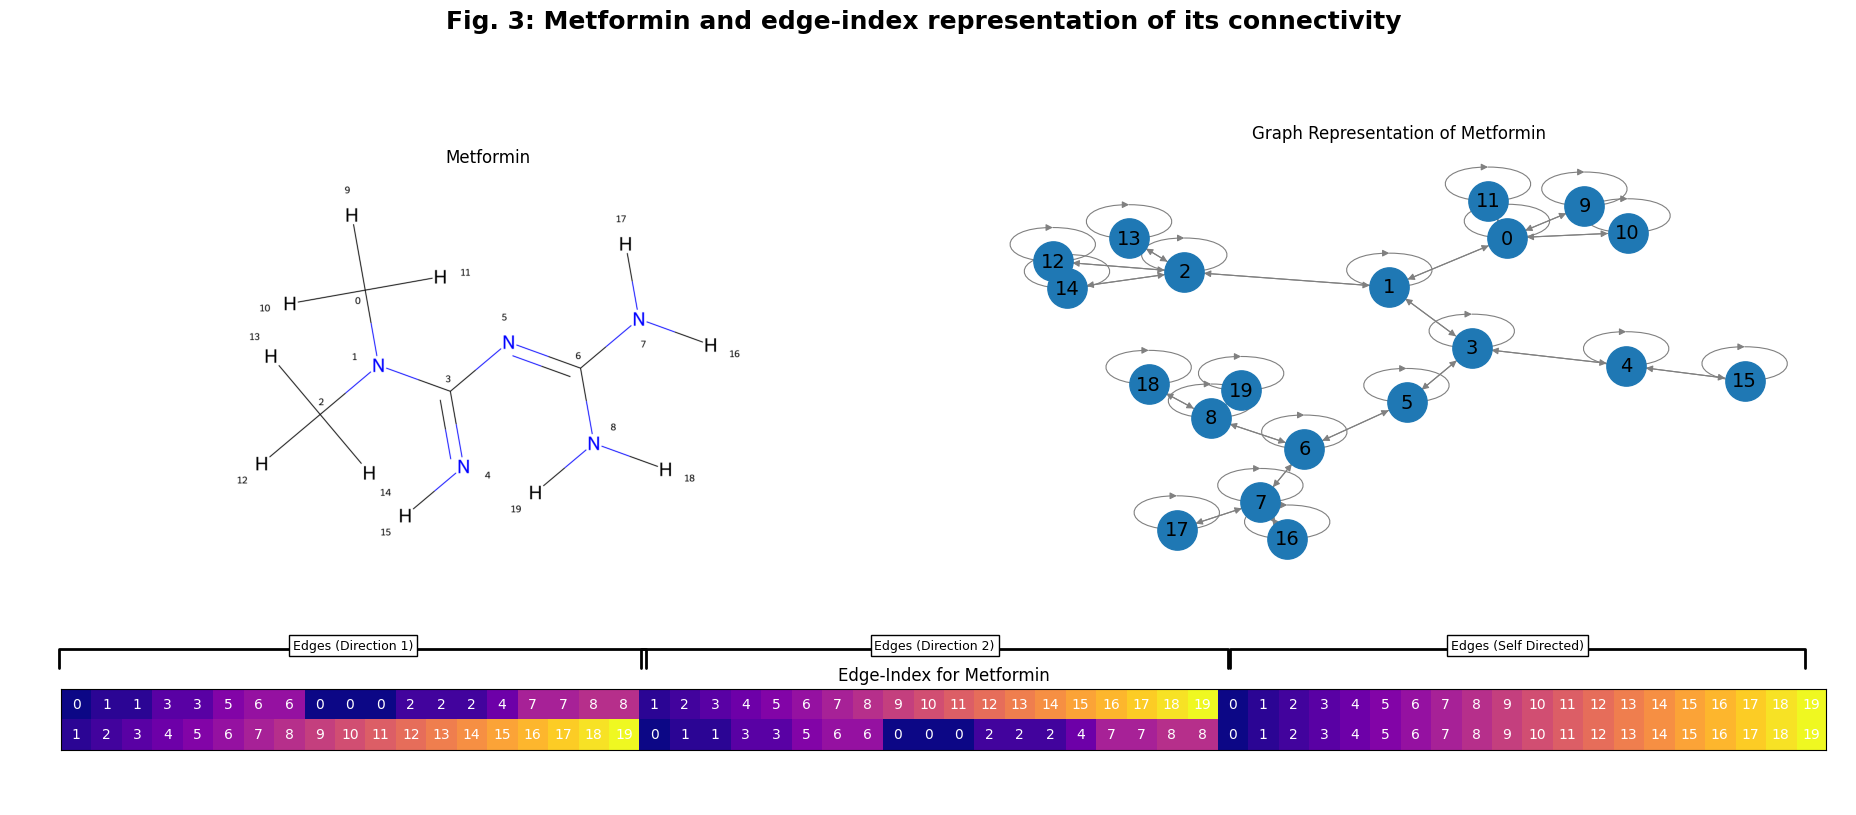

In [ ]:
makefig3()

## **Implementing The Graph Convolutional Network Class**

### **Creating a Class for a GCN-model**
My final GCN class uses the GCNConv-layer from PyTorch geometric to do the convolutions. The class has certain attributes like:

* **dim_in**: The input dimension
* **dim_in**: Dimension of the weight matrix used in the convolutional layer.
* **n_convolutional_layers**: Number of convolutional layers (no. of convolutions)
* **dense_layers**: Tuple of dense layers proceeding the GCNLayers with each element being no. of nodes. For example (10, 5, 1) means the model has 3 dense layers after the GCN Layers with 10, 5 and 1 node(s) respectively.

* **dropout_rate**: A single dropout layer is placed in between the first and remaining convolutional layers. This sets the dropout rate for that layer.

In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class"""
    def __init__(self, dim_in, dim_h, n_convolutional_layers = 5, dense_layers = (50, 25, 1), dropout_rate = 0.5):
        super().__init__()

        self.dim_h = dim_h
        self.dim_in = dim_in

        self.n_convolutional_layers = n_convolutional_layers
        self.dense_layers = dense_layers
        self.dropout_rate = dropout_rate

        self.bnorm = nn.BatchNorm1d(self.dim_h)

        self.conv1 = GCNConv(self.dim_in, self.dim_h)
        self.convolutional_layers = [GCNConv(self.dim_h, self.dim_h) for i in range(self.n_convolutional_layers - 1)]

        self.dense_layers = [torch.nn.Linear(self.dim_h, dense_layers[0])] + [torch.nn.Linear(dense_layers[i-1], dense_layers[i]) for i in range(1, len(dense_layers))]


    def forward(self, data):
        """Data is a torch.Data object with at least properties x and edge_index."""
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)  # Do the convolution of the input

        for i in range(self.n_convolutional_layers - 1):  # Do all the other 'intermediary' convolutions
          x = self.convolutional_layers[i](x, e)

        x = gnn.global_mean_pool(x, data.batch)           # Perform reduction with a global_mean_pool to reduce to molecular embeddings


        x = nn.Dropout(p=self.dropout_rate)(x)

        for layer in self.dense_layers[:-1]:              # Apply  all the dense layers except the output layers. These all get activated with ReLU.
          x = layer(x)
          x = torch.nn.functional.relu(x)

        x = self.dense_layers[-1](x)                      # Apply the final output layer (No activation!)


        return x

### **Creating a Class for a Model-Trainer**
The training is facilitated by the class GNNTrainer. This model handles our loss-function (criterion), the optimizer (you can pass any torch optimizer to it), the learning rate and number of epochs to be trained. It also handles the actual training by calling on the model to forward propagate and backpropagate. Finally it also handles making predictions on new data, as well recording the loss on training and validation sets, which we can look on after training.

In [ ]:
class GNNTrainer():

  def __init__(self, model, criterion, optimizer, tqdm_disabled = False):
    self._model = model
    self._criterion = criterion
    self._optimizer = optimizer
    self.tqdm_disabled = tqdm_disabled

  def train_one_epoch(self, d):
    out = self.model(d)
    loss = self.criterion(out, d.y)   # Computes the loss
    loss.backward()                   # Derives gradients.
    self.optimizer.step()             # Updates trainable parameters based on gradients.
    self.optimizer.zero_grad()        # Clears the gradients.
    return loss

  @torch.no_grad
  def validate_one_epoch(self, val_d):
    out = self.model(val_d)
    loss = self.criterion(out, val_d.y)
    return loss

  def initialize_loader(self, datalist):
    self.dataloader = GraphDataLoader(datalist, batch_size=self.batch_size)

  def initialize_val_dataloader(self, val_datalist):
    self.val_dataloader = GraphDataLoader(val_datalist)

  def train(self, datalist, valdatalist, eta = 0.001, batch_size = 16, n_epochs = 50):
    self.model = self._model
    self.criterion = self._criterion()
    self.optimizer = self._optimizer(self.model.parameters(), lr = eta)
    self.batch_size = batch_size

    self.initialize_loader(datalist)
    self.initialize_val_dataloader(valdatalist)

    self.model.train()

    self.loss_history = []
    self.val_loss_history = []

    for epoch in tqdm(range(n_epochs), disable = self.tqdm_disabled):
      epoch_loss = 0
      epoch_val_loss = 0

      for d in self.dataloader:
        loss = self.train_one_epoch(d)
        epoch_loss += loss.detach()

      for val_d in self.val_dataloader:
        val_loss = self.validate_one_epoch(val_d)
        epoch_val_loss += val_loss.detach()

      self.loss_history.append((epoch_loss / len(self.dataloader)))
      self.val_loss_history.append((epoch_val_loss / len(self.val_dataloader)))

  @torch.no_grad
  def predict(self, dlist):
      self.model.eval()
      return torch.tensor([self.model(i).detach() for i in tqdm(dlist, disable = self.tqdm_disabled)])

## **Training the model**

In the first go i will train the model using a feature matrix in which the following features have been computed for each molecule:

* **atom_type**: one-hot encoding of atomic type / number
* **aromaticitiy**: boolean, 1 if atom is part of aromatic system, otherwise 0
* **degree**: one-hot-encoding of the atoms degree
* **hybridization**: one-hot-encoding of hybridization (SP1, SP2, SP3...)
* **n_hydrogens**: number of hydrogens bonded to that atom. One hot encoded.
* **valence**: one-hot-encoding of the valence of that atom.
* **partial charges**: rdkit-calculated partial charges
* **coulomb_matrix**: a simplified version of a coulomb matrix that is generated by generating an rdkit conformer and calculating interatomic distances, and then using coulombs law to calculate electrostatic potentials between the nuclei.
* **bond_type**: one-hot encoding of which type of bonds that are emanating from that atom. Bonds can be single, double, triple, quadruple as well as aromatic.
* **formal_charge**: One-hot encoded formal charge. Molecules in this dataset only have atoms with formal charge of -1, 0 or +1. These are also one-hot encoded.

My experience is that the model performs better with features one-hot-encoded than numerical, for example in the case of the formal charge, which we could represent numerically. But one-hot-encoding seems to give better performance.

The model seems to run best with 7 convolutional layers, followed by a small dense layer of 25 neurons and finally the output layer.

In [ ]:
%%capture

featurizer = FeaturizeMols(feature_list = ["atom_type", "aromaticity", "degree", "hybridization", "n_hydrogens", "bond_type", "partial_charges", "valence", "formal_charge", "coulomb_matrix"], smiles = data.smiles.values)
all_data = np.vstack([featurizer.gen(smiles) for smiles in data.smiles.values]) # Here i generate the features for the entire dataset to be able to retrieve the mean and standard deviation across all generated features

sc = MinMaxScaler()#StandardScaler()
sc.fit(all_data)    # Here i fit the standard scaler to the full data (generated features across all atoms in the entire dataset).

train_data, test_data = train_test_split(data, train_size = 0.8)    # Allocate 80 pct. of data for training
test_data, val_data = train_test_split(test_data, train_size = 0.5) # Split the remainign 20 pct. into test and validation

X_train, y_train = train_data.smiles.values, train_data["measured log solubility in mols per litre"].values
X_test, y_test = test_data.smiles.values, test_data["measured log solubility in mols per litre"].values
X_val, y_val = val_data.smiles.values, val_data["measured log solubility in mols per litre"].values

# Below i create lists of PYG-data objects for the trainin, test, and val sets. Like mentioned the data objects holds our X, y and edge-index matrices.
# When creating the features for each molecule (X) their are transformed (standardized/normalized) by calling sc.transform
# MinMax scalign seems to work better than standard-scaling on this dataset.
train_dlist = [CreatePYGData(sc.transform(featurizer.gen(smiles)), EdgeIndexFromSmiles(smiles), y) for smiles, y in zip(tqdm(X_train), y_train)]
test_dlist = [CreatePYGData(sc.transform(featurizer.gen(smiles)), EdgeIndexFromSmiles(smiles), y) for smiles, y in zip(tqdm(X_test), y_test)]
val_dlist = [CreatePYGData(sc.transform(featurizer.gen(smiles)), EdgeIndexFromSmiles(smiles), y) for smiles, y in zip(tqdm(X_val), y_val)]

In [ ]:
y_train_copy = y_train    # Copy these for use later on
y_test_copy = y_test
y_val_copy = y_val

In [ ]:
input_dim = train_dlist[0].x.shape[1]       # The input dimension / number of features
GCNTrainer = GNNTrainer(model = GCN(dim_in = input_dim, dim_h = 48, n_convolutional_layers = 7, dense_layers = (25, 1), dropout_rate = 0.0), criterion = torch.nn.MSELoss, optimizer = torch.optim.Adam)
GCNTrainer.train(train_dlist, val_dlist, n_epochs = 70, eta = 0.015, batch_size = 32)

100%|██████████| 70/70 [01:04<00:00,  1.08it/s]


### **Evaluating the loss**
Below I've plotted the training and validation loss for the model. The loss is converging nicely and the training and validation loss follow each other nicely. There is seemingly no case of heavy overfitting.

100%|██████████| 113/113 [00:00<00:00, 287.58it/s]


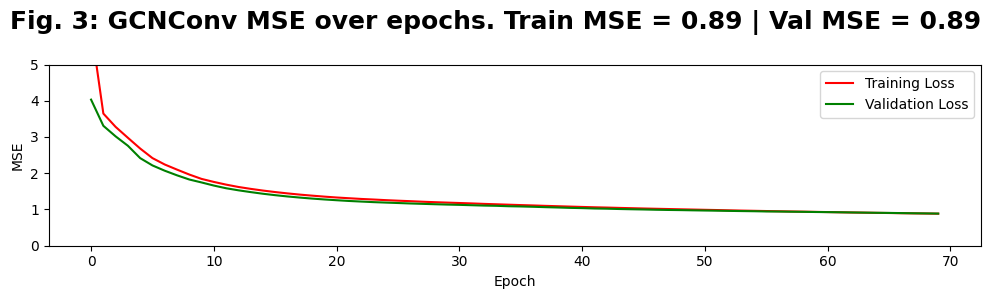

In [ ]:
fig, ax = plt.subplots(figsize = (10,3))
ax.plot(GCNTrainer.loss_history, color = "red", label = "Training Loss")
ax.plot(GCNTrainer.val_loss_history, color = "green", label = "Validation Loss")
ax.set_ylim(0,5)
lf = torch.nn.MSELoss()
train_preds = GCNTrainer.predict(train_dlist)
val_preds = GCNTrainer.predict(val_dlist)

fin_train_mse = round(lf(train_preds, torch.tensor(y_train)).item(), 2)
fin_val_mse = round(lf(val_preds, torch.tensor(y_val)).item(), 2)

fig.suptitle(f"Fig. 3: GCNConv MSE over epochs. Train MSE = {round(fin_train_mse, 2)} | Val MSE = {round(fin_val_mse, 2)}", fontweight = "bold", fontsize = 18)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
plt.legend()
plt.tight_layout()

##### **Evaluating Predictions**

In [ ]:
lf = torch.nn.MSELoss() # instantiate new loss-func (MSE) to calculate final MSE's

torch_train_preds = GCNTrainer.predict(train_dlist)
torch_test_preds = GCNTrainer.predict(test_dlist)
torch_val_preds = GCNTrainer.predict(val_dlist)

torch_train_mse = round(lf(torch_train_preds, torch.tensor(y_train)).item(), 2)
torch_test_mse = round(lf(torch_test_preds, torch.tensor(y_test)).item(), 2)
torch_val_mse = round(lf(torch_val_preds, torch.tensor(y_val)).item(), 2)
std_vec = torch.tensor(y_train.mean()).expand(y_train.shape[0],1).ravel()                             # vector of null predictions, same size as y_train but every value is the mean of y_train
null_mse = round(lf(std_vec, torch.tensor(y_train)).item(), 2)

100%|██████████| 113/113 [00:00<00:00, 300.45it/s]


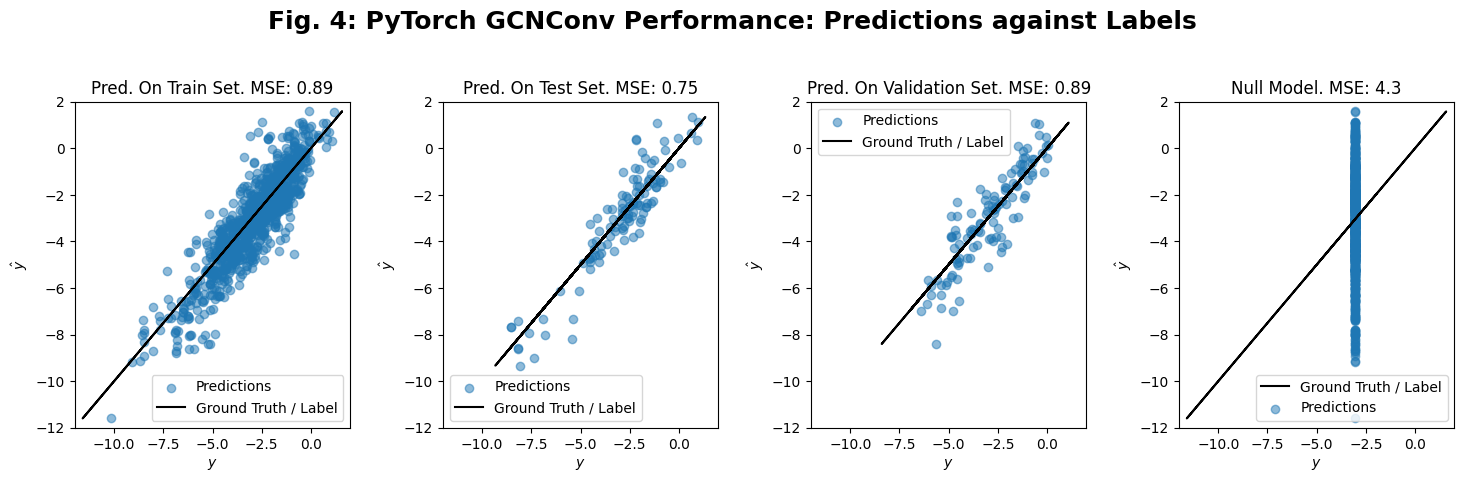

In [ ]:
makefig4()

The model is performing quite well on both train, test and validation sets. It is by all means out performing a null model that simply predicts  the mean across the entire dataset.  

## **Comparing With DeepChem**
It will be interesting to see how my own model and featurization techniques hold up against DeepChem. Below i will use DeepChem to likewise train a GCN to predict on the ESOL-dataset.

In [ ]:
%%capture
!wget https://github.com/deepchem/deepchem/raw/master/datasets/delaney-processed.csv    # Download ESOL locally

### **Code for the DeepChem GraphConv Model**

In [ ]:
delaney_tasks = ["measured log solubility in mols per litre"]
dc_featurizer = dc.feat.ConvMolFeaturizer()
dataset_file = 'delaney-processed.csv'

loader = dc.data.CSVLoader(
    tasks = delaney_tasks, feature_field = "smiles", featurizer = dc_featurizer
)

dataset = loader.featurize(dataset_file, shard_size = 8192)
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)]

for transformer in transformers:
  dataset = transformer.transform(dataset)

splitter = dc.splits.IndexSplitter()

train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

/usr/local/lib/python3.10/dist-packages/deepchem/data/data_loader.py:161: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  warnings.warn(


In [ ]:
batch_size = 128
n_feat = 75
n_tasks = len(delaney_tasks)
model = dc.models.GraphConvModel(n_tasks, batch_size = batch_size, mode='regression', n_feat = n_feat)

n_epochs = 75

metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric_string = "mean_squared_error"

dc_train_losses, dc_test_losses, dc_valid_losses = [], [], []

for epoch in tqdm(range(n_epochs)):
  """Here i am technically just running one-epoch at a time, for n_epoch epochs. Just so i can evaluate on the train, test and valid sets and save the losses to plot them later on."""
  model.fit(train_dataset, nb_epoch=1)
  dc_train_loss = model.evaluate(train_dataset, [metric], transformers)[metric_string]
  dc_test_loss = model.evaluate(test_dataset, [metric], transformers)[metric_string]
  dc_valid_loss = model.evaluate(valid_dataset, [metric], transformers)[metric_string]

  dc_train_losses.append(dc_train_loss)
  dc_test_losses.append(dc_test_loss)
  dc_valid_losses.append(dc_valid_loss)

100%|██████████| 75/75 [01:06<00:00,  1.12it/s]


### **Evaluating the loss of the DeepChem model**
The loss is converging decently, but overfitting is pretty apparent here. There is an increasing gap between the curve for training and val. loss as the training proceeds.

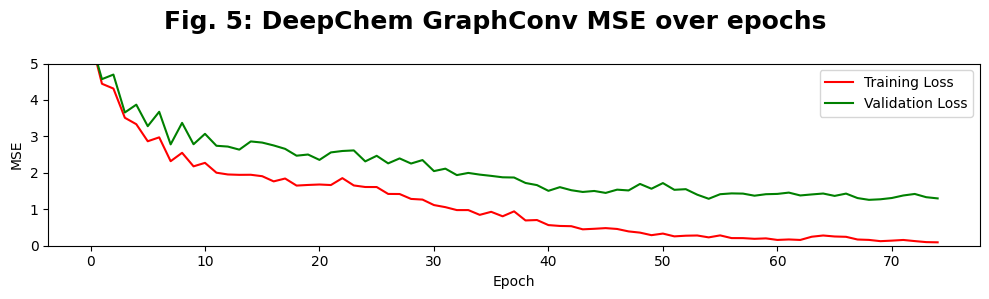

In [ ]:
makefig5()

In [ ]:
dc_train_preds = model.predict(train_dataset)
dc_test_preds = model.predict(test_dataset)
dc_valid_preds = model.predict(valid_dataset)

dc_y_train, dc_y_test, dc_y_valid = train_dataset.y, test_dataset.y, valid_dataset.y

# We need to untransform the data before plotting, to get the 'real' y-values/solubility values.

for transformer in transformers:
  dc_y_train = transformer.untransform(dc_y_train)
  dc_y_test = transformer.untransform(dc_y_test)
  dc_y_valid = transformer.untransform(dc_y_valid)
  dc_train_preds = transformer.untransform(dc_train_preds)
  dc_test_preds = transformer.untransform(dc_test_preds)
  dc_valid_preds = transformer.untransform(dc_valid_preds)

dc_train_mse, dc_test_mse, dc_valid_mse = model.evaluate(train_dataset, [metric], transformers)[metric_string], model.evaluate(test_dataset, [metric], transformers)[metric_string], model.evaluate(valid_dataset, [metric], transformers)[metric_string]

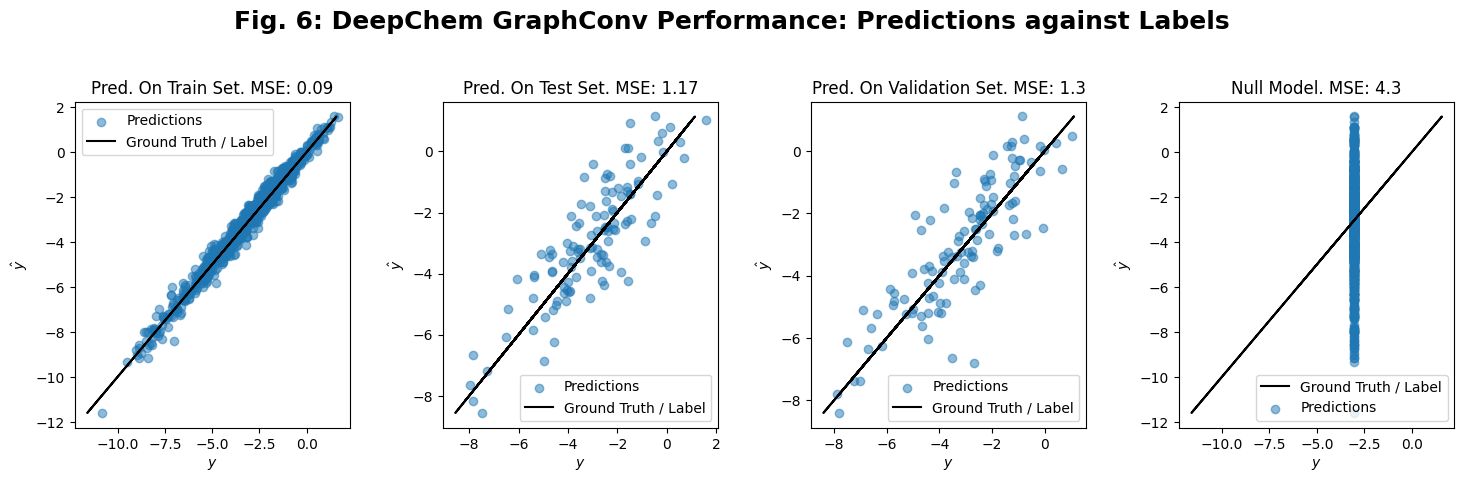

In [ ]:
makefig6()

It seems that at least with these default settings, that the performance of the DeepChem GraphConv model is a little bit worse than my model (at least on this train-test split). DeepChem achieves a bit of a higher loss and val. sets compared to my PyTorch model, and it is also apparent that the deepchem model is quite heavily overfitted, because the predictions on the train set are very low (around 0.1) while the predictions on test and validation set are well over 1.

In comparison my PyTorch model has more comparable values for the MSE on both train, test and validation. For the rest of the assignment i'll use the PyTorch model to answer the various questions, since it seems to work the best.



## **How does the choice of training and test-set influence the models performance?**

For this, I'll run a loop of 10 iterations where we run a train test split, train the model and make predictions on the train, test and validation set.

### **Code for testing MSE on random splits**

In [ ]:
import random

In [ ]:
train_err, test_err, val_err = [], [], [] # assign three empty lists to the three variables that can hold our

n_iters = 10

# to speed up computation, i start by creating the PYG dataobjects for the full dataset, and then randomly sample them to
# prevent having to featurize every iteration of the loop

full_data = data
full_data_X = data.smiles.values
full_data_y = full_data["measured log solubility in mols per litre"]

full_data_dlist = [CreatePYGData(featurizer.gen(smiles), EdgeIndexFromSmiles(smiles), y) for smiles, y in zip(full_data_X, full_data_y)]

for iteration in tqdm(range(n_iters)):


  zipd = list(zip(full_data_dlist, full_data_y))

  random.shuffle(zipd)

  full_data_dlist, full_data_y = zip(*zipd) # unzip again

  train_dlist = full_data_dlist[:904]                # Allocate 80 pct. of data to train_data
  test_dlist = full_data_dlist[904:(904+112)]        # and 10 pct. to test and valid respectively
  val_dlist = full_data_dlist[904:(904+112+112)]

  y_train = full_data_y[:904]
  y_test = full_data_y[904:(904+112)]
  y_val = full_data_y[904:(904+112+112)]

  input_dim = train_dlist[0].x.shape[1]

  GCNTrainer = GNNTrainer(model = GCN(dim_in = input_dim, dim_h = 48, n_convolutional_layers = 7, dense_layers = (25, 1), dropout_rate = 0.0), criterion = torch.nn.MSELoss, optimizer = torch.optim.Adam, tqdm_disabled = True)
  GCNTrainer.train(train_dlist, val_dlist, n_epochs = 50, eta = 0.0025, batch_size = 32)

  train_preds = GCNTrainer.predict(train_dlist)
  test_preds = GCNTrainer.predict(test_dlist)
  val_preds = GCNTrainer.predict(val_dlist)

  lf = torch.nn.MSELoss() # instantiate new loss-func (MSE) to calculate final MSE's

  train_mse = round(lf(train_preds, torch.tensor(y_train)).item(), 2)
  test_mse = round(lf(test_preds, torch.tensor(y_test)).item(), 2)
  val_mse = round(lf(val_preds, torch.tensor(y_val)).item(), 2)

  train_err.append(train_mse)
  test_err.append(test_mse)
  val_err.append(val_mse)

<ipython-input-21-7c6113656198>:48: RuntimeWarning: divide by zero encountered in divide
  m = np.outer(z, z) / d
100%|██████████| 10/10 [12:30<00:00, 75.08s/it]


### **Evaluating the errors**

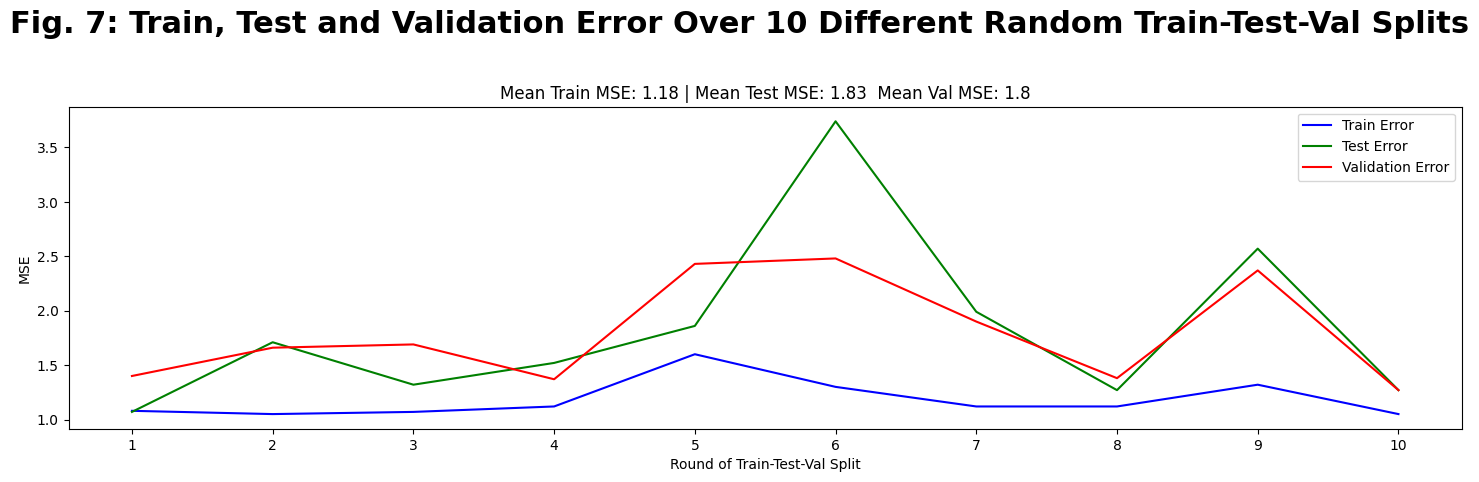

In [ ]:
makefig7()

Like in the previous assignment, we see little variability in the training set, which makes sense because it is the biggest set containing many molecules with a wide range of solubilities. And also it is the set we are minimizing the error on during training. The test and validation sets show more variability, which is likely due to the types of molecules ending up in the test/val-sets. However we can see that the highest MSE is around 2.4 on the 3rd random split, which is still way better than the null-model. And when we take the mean of the MSEs over all rounds of train-test-splitting (see top of plot) we still get some pretty good MSE-values. So the takeaway is that sure there is some variability depending on how we do the train-test-split, but the model is actually generalizing to the test/val-sets pretty nicely independent of the split.

### **Correlation Between Error and Solubility**

In [ ]:
preds = [torch_train_preds, torch_test_preds, torch_val_preds]
labels = [y_train_copy, y_test_copy, y_val_copy]
errors = []
abs_errors = []

for pred, label in zip(preds, tqdm(labels)):
  error = pred - np.array(label)
  errors.append(error)
  abs_errors.append(abs(error))

 67%|██████▋   | 2/3 [00:00<00:00, 94.21it/s]


First, let's look at the distribution of the labels and the errors alike. I've plotted both the distribution of errors and the absolute errors. From the absolute error distributions we can see the tendency of the model to predict wrong overall. From the 'raw' errors (by which i mean not taking the absolute value) it would also be possible to see if there is a tendency to predict too low or too high. It seems like the error values are actually pretty normally distributed and centered around zero, so it seems like the model is fairly equally prone to come with a too high predictions, as predictions that are too low. If you look closely maybe you could argue that a negative error is slightly more common, so maybe the model has a slight tendency to predict molecules to be more insoluble than they really are, rather than predicting them to be more soluble than they are.

In row two i've plotted the absolute errors vs the labels for the three splits, to investigate if there is general correlation between the error (no matter if its a positive or negative error) and the label (solubility value). It is quite apparent that the very soluble and very insoluble molecules tend to have a larger error. It is noteworthy that it is also the case for the predictions made on the training set, because that implies that it is a constraint inherent to the model, and not simply because the model fails to generalize on unforeseen data.

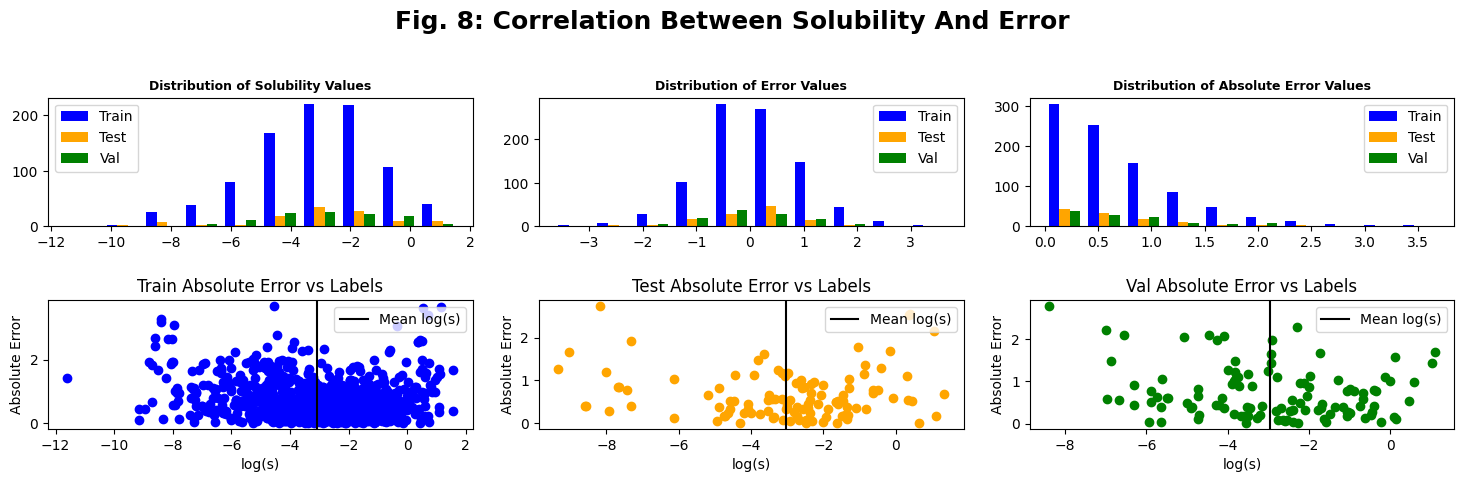

In [ ]:
makefig8()

## **Which kind of molecules have large errors?**
If we just split the data once and take for example the 10 molecules with the highest errors in the test/validation set, it can be hard to argue that those molecules are inherently hard to make predictions on because of their chemical features. It could just as likely be the case that molecules with those chemical features just not have been sufficiently represented in the training set, and that the model for that reason can't make good predictions on them.

To investigate further we can try to run many random train-test splits and save the molecules and their associated errors. This monte-carlo like approach should give us an idea of whether some molecules are consistently prone to large errors regardless of how the data is split.

It is apparent that the absolute error has a tendency to be larger for molecules that have solubilities that fall in the far ends/tails of the normal distribution made up by the solubilities in the dataset as a whole.

But there are also some molecules with large errors that have a solubility just around the mean of whole training set. That implies that at least the whole-molecule property of having a solubility similar to most molecules in the training-set doesn't guarantee a good prediction. So perhaps there are certain molecular features/fragments/groups that lead to a solubility close to the mean, that are not found in a lot of the other molecules.

It would be interesting to see what the molecules that consistently have large errors and small errors look like. And also how similar both groups are to the training set. We could examine this using Tanimoto similarities.

Running 100 iterations takes a real long time and i can't afford to rerun everytime i open the notebook, so I've saved the resulting data in my GitHub and then i load it in. You can still see the code i used to generate the data if you expand the section below.


### **Code to evaluate average error over 100 random train-test splits**

~~~
full_data = data
smiles, y = full_data.smiles.values, full_data["measured log solubility in mols per litre"].values

data_size = len(full_data)
train_size = round(1128 / 100 * 80)
test_size = round(1128 / 100 * 10)

full_dlist = [CreatePYGData(featurizer.gen(smiles), EdgeIndexFromSmiles(smiles), y) for smiles, y in zip(smiles, tqdm(y))] # list of PyTorch Data Objects (This just holds the data in the way PyTorch prefers)

n_iters = 100

error_vector = np.zeros((data_size, 1)) # empty vector to hold accumulated errors

for iteration in tqdm(range(n_iters)):
  rand_idx = np.random.permutation(data_size)
  train_idx = rand_idx[:train_size]
  test_idx = rand_idx[train_size : (train_size+test_size)]
  y_test = y[test_idx].reshape(-1,1)

  train_dlist = [full_dlist[i] for i in train_idx]
  test_dlist = [full_dlist[i] for i in test_idx]

  input_dim = train_dlist[0].x.shape[1]
  GCNTrainer = GNNTrainer(model = GCN(dim_in = input_dim, dim_h = 33, n_convolutional_layers = 7, dense_layers = (25, 1)), criterion = torch.nn.MSELoss, optimizer = torch.optim.Adam, tqdm_disabled = True)
  GCNTrainer.train(train_dlist, test_dlist, n_epochs = 25, eta = 0.0025, batch_size = 64*4)

  test_preds = GCNTrainer.predict(test_dlist).numpy().reshape(-1,1)
  errors = np.absolute(np.array((test_preds - y_test)))
  error_vector[test_idx] = error_vector[test_idx] + errors  # increment the original indexes in the error_vector by the absolute error for the molecule at that index
  ~~~
  `

### **Visualizing the results**

In [ ]:
%%capture
!wget https://github.com/jrytved/mlmol_files/raw/main/errors.txt  # send GET-request to the errors saved in my github

In [ ]:
accumulated_errors = np.loadtxt("errors.txt")
average_errors = accumulated_errors / 100 # The errors are accumulated (summed) over 100 iterations, so to get the average error we divide by 100

In [ ]:
n = 50

largest_errors_idx = average_errors.argsort(axis = 0)[-n:] # get indices of the n molecules with largest errors.
largest_error_smiles = data.smiles.astype(str).values[largest_errors_idx]
largest_error_mols = [Chem.MolFromSmiles(i) for i in largest_error_smiles.squeeze().tolist()]

lowest_errors_idx = average_errors.argsort(axis = 0)[:n] # get indices of the n molecules with smallest errors.
lowest_error_smiles = data.smiles.astype(str).values[lowest_errors_idx]
lowest_error_mols = [Chem.MolFromSmiles(i) for i in lowest_error_smiles.squeeze().tolist()]

Below i have drawn out the largest error mols to begin with. The subscript is the average error over the 100 random train-test-splits. There is definetely a trend in these molecules. There are quite a few alkanes, and also a lot of compounds consisting of cyclic hydrocarbons fused in different ways. Most have no substituents but a few have methyl groups or halogens bonded. Then there are very small molecules, consisting only of a few atoms, like bromocholoromethane, dibromochloromethane, iodomethane, idooethane and so on. Finally we see a few molecules that are heavily substituted with oxygen, sulphur and halogens.

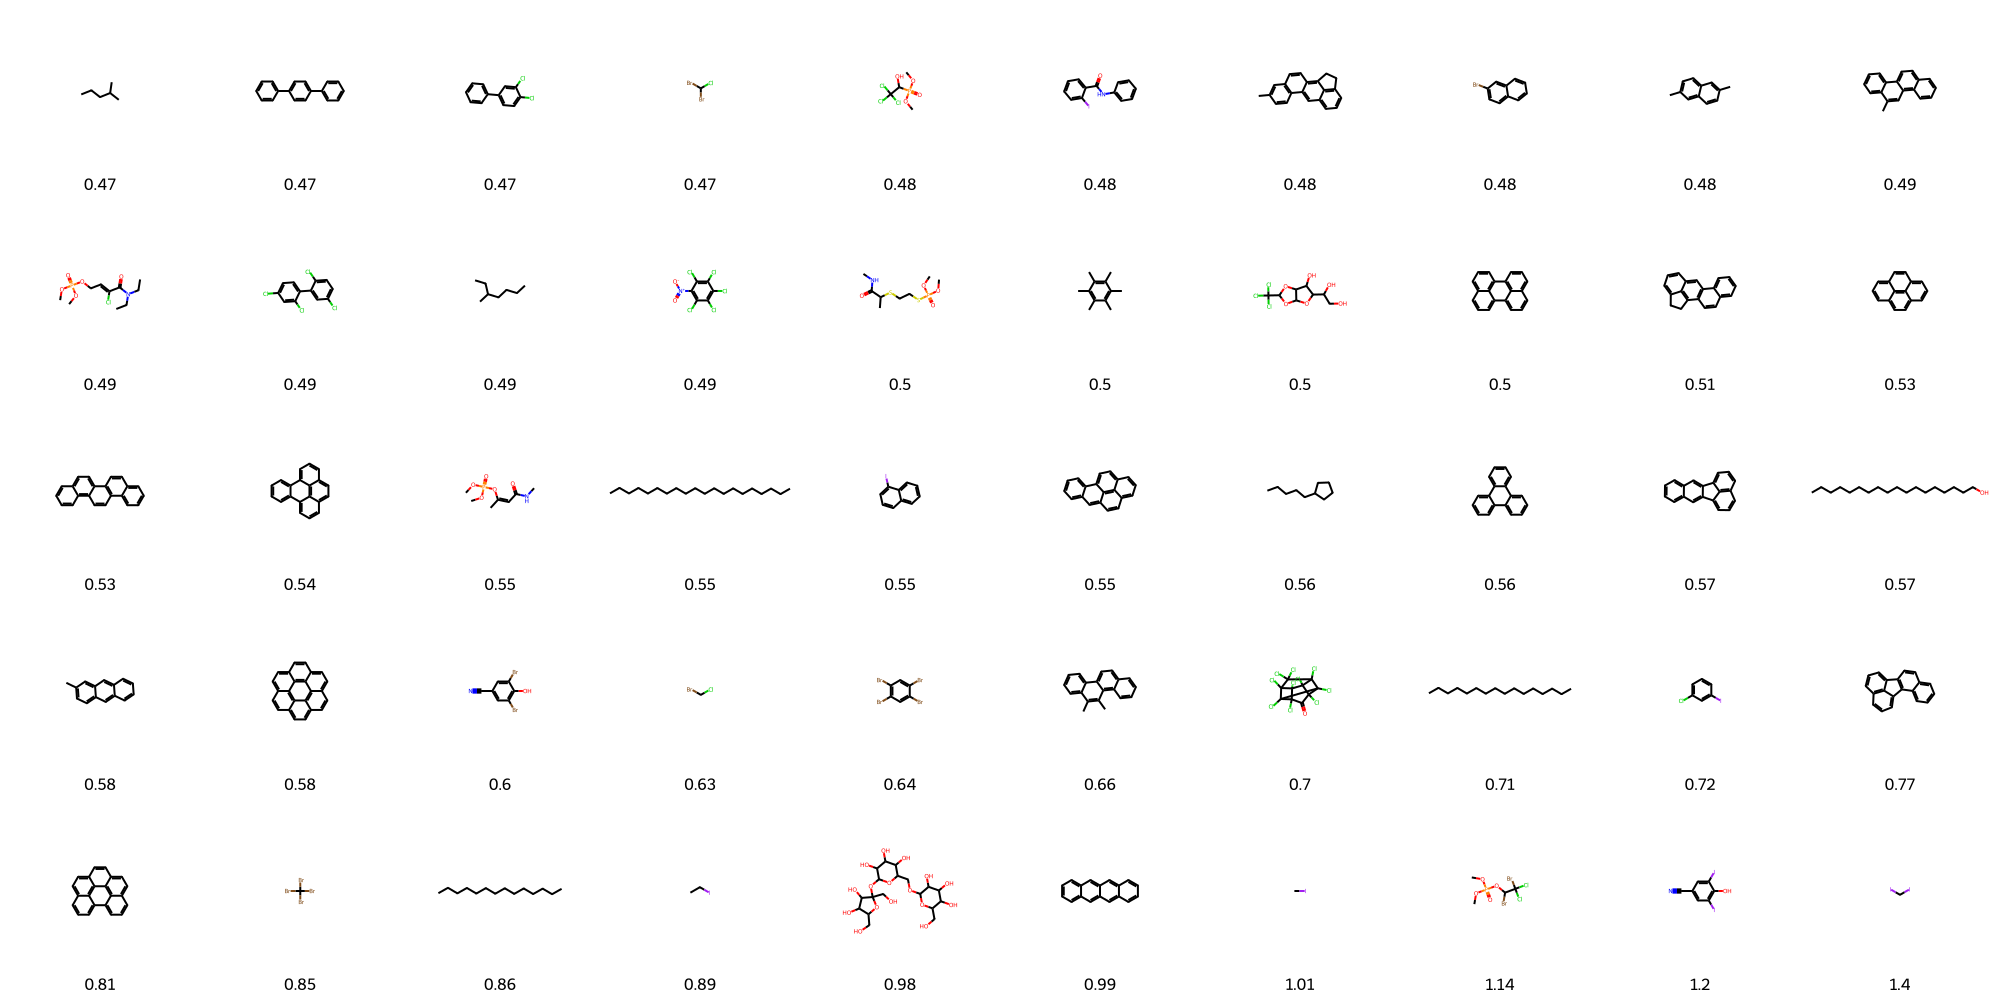

In [ ]:
Chem.Draw.MolsToGridImage(largest_error_mols, molsPerRow = 10, legends = average_errors[largest_errors_idx].round(2).astype(str).tolist())

Next we can look at the lowest error molecules. They actually look quite similar. For example they tend to contain a lot of oxygen, nitrogen and some of them sulphur. But we don't see a lot of halogens. Most of them are pretty comparable in size. They are not extremely small, or extremely large. The vast majority contain an aliphatic chain with some kind of branching, and then hydroxyl, carbonyl or carboxylic acids substituted in. Also single benzene rings with substituents are quite prevalent.

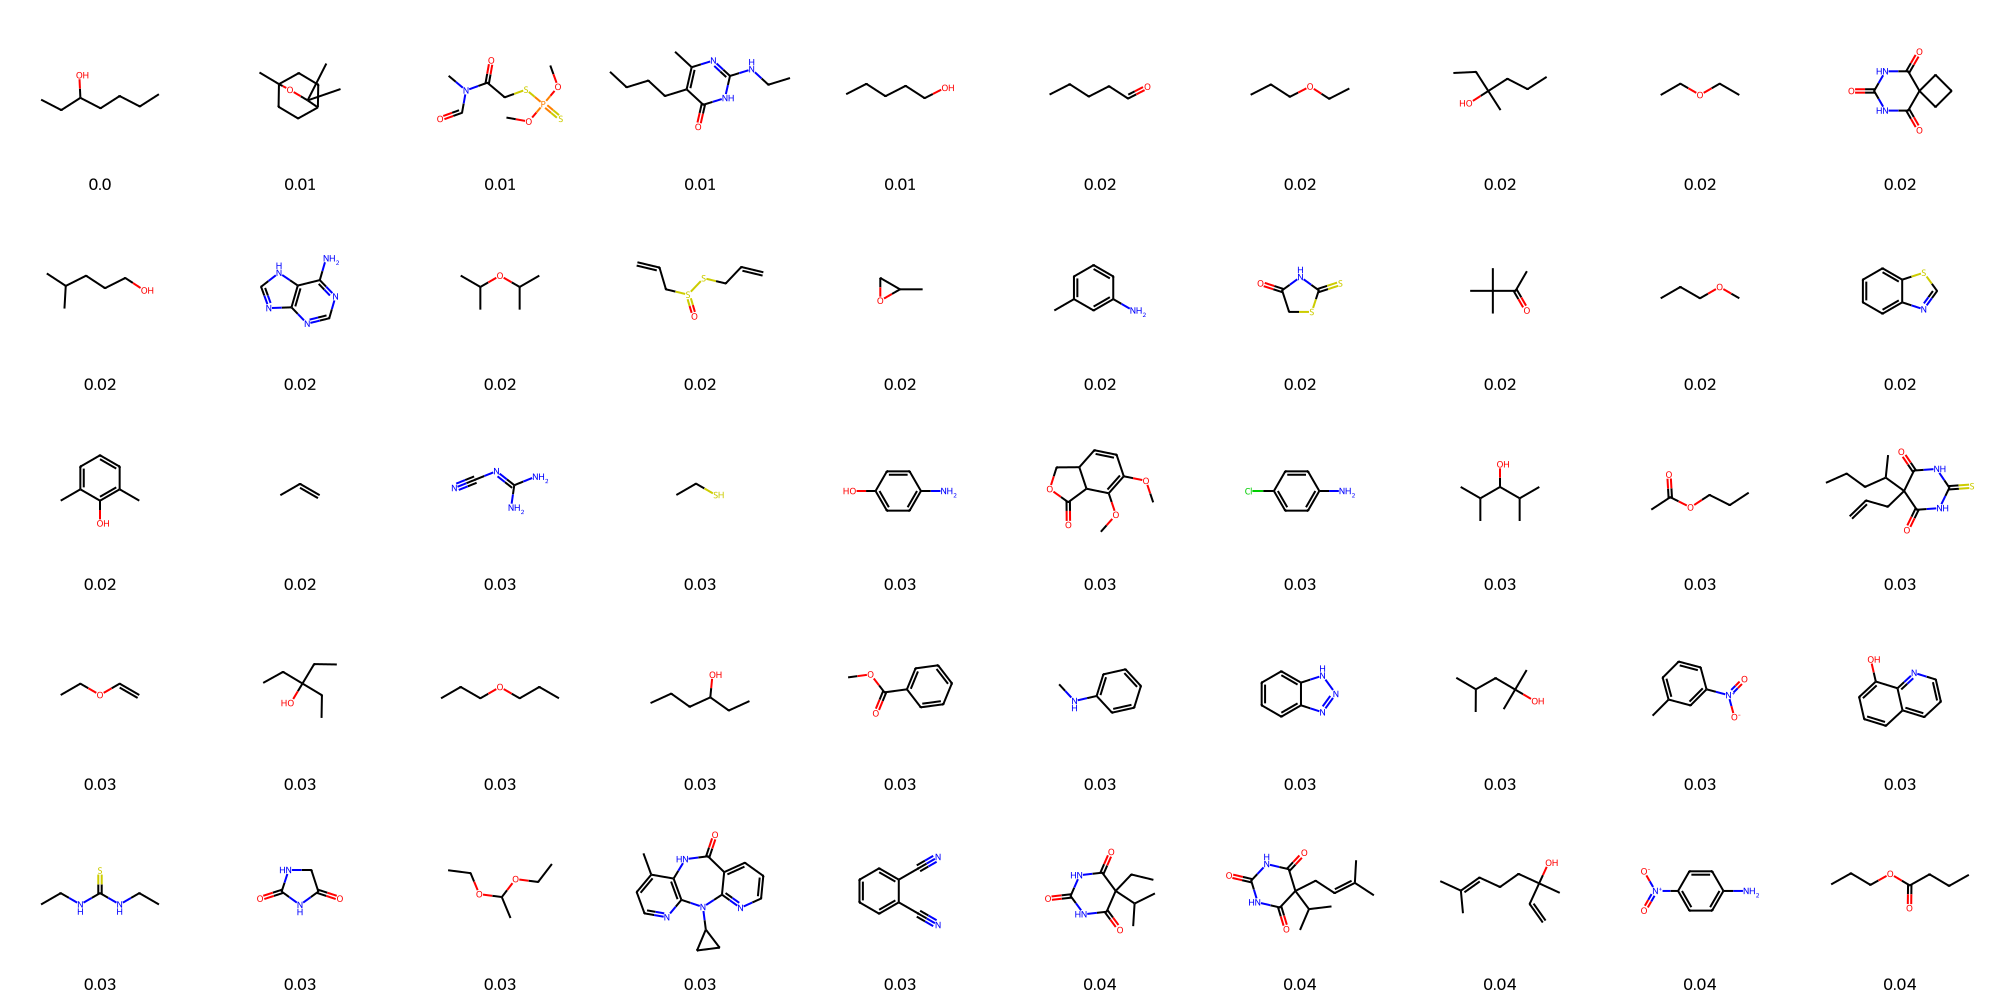

In [ ]:
Chem.Draw.MolsToGridImage(lowest_error_mols, molsPerRow = 10, legends = average_errors[lowest_errors_idx].round(2).astype(str).tolist())

To take a more quantitative approach to how the molecules differ, i will use RDKit to calculate some descriptors for the low and high error molecules respectively.

### **Code for counting fragments and computing descriptors**

In [ ]:
# How do the groups differ in terms of size (total no. atoms)?


large_error_n_atoms = [mol.GetNumAtoms() for mol in largest_error_mols]
low_error_n_atoms = [mol.GetNumAtoms() for mol in lowest_error_mols]

# Are some fragments overrepresented?
frags = [
    Chem.Fragments.fr_aldehyde,
    Chem.Fragments.fr_alkyl_halide,
    Chem.Fragments.fr_SH,
    Chem.Fragments.fr_Al_OH,
    Chem.Fragments.fr_sulfide,
    Chem.Fragments.fr_ester,
    Chem.Fragments.fr_ether,
    Chem.Fragments.fr_Ar_NH,
    Chem.Fragments.fr_Ar_OH,
    Chem.Fragments.fr_C_O,
    Chem.Fragments.fr_unbrch_alkane,
    Chem.Fragments.fr_phenol,
    Chem.Fragments.fr_ketone,
    Chem.Fragments.fr_lactone,
    Chem.Fragments.fr_bicyclic
]

group_names = ["Aldehyde", "Alkyl Halide", "Thio", "Hydroxyl", "Sulfide", "Ester","Ether", "Aromatic NH", "Aromatic OH", "Carbonyl", "Unbranched Alk.", "Phenol", "Ketone", "Lactone", "Bicyclic Ring"]

# Two arrays to store the count of fragments in
low_error_frag_array = np.zeros((len(lowest_error_mols), len(frags)))
large_error_frag_array = np.zeros((len(largest_error_mols), len(frags)))

for i in range(n):
  for j, frag in enumerate(frags):
    low_error_frag_array[i][j] = frag(lowest_error_mols[i])
    large_error_frag_array[i][j] = frag(largest_error_mols[i])

low_error_frag_array_sum = low_error_frag_array.sum(axis = 0)
large_error_frag_array_sum = large_error_frag_array.sum(axis = 0)

### **Visualizing the results**
In fig. 9 there are two plots. On the left we see the sum of counts of certain fragments across all the large error molecules and all the low error molecules respectively. Some groups/fragments like thio-groups, sulfides and phenols occur equally in both groups. But we can see that alkyl halides are vastly overrepresented in the large error molecules. Likewise the large error molecules have a way higher count of unbranched alkanes (fragments only counted if more than 4 C-atoms) as well as bicyclic rings. The bicyclic ring fragments are counted as fragments where two rings are fused together. On the other hand, esters, ethers, carbonyl groups as well as aromatic amines are more common in the low error molecules.

On the right we see the size of the molecules (simply the count of atoms). It is here very obvious that the large error molecules are generally large, while the low error molecules are generally small.

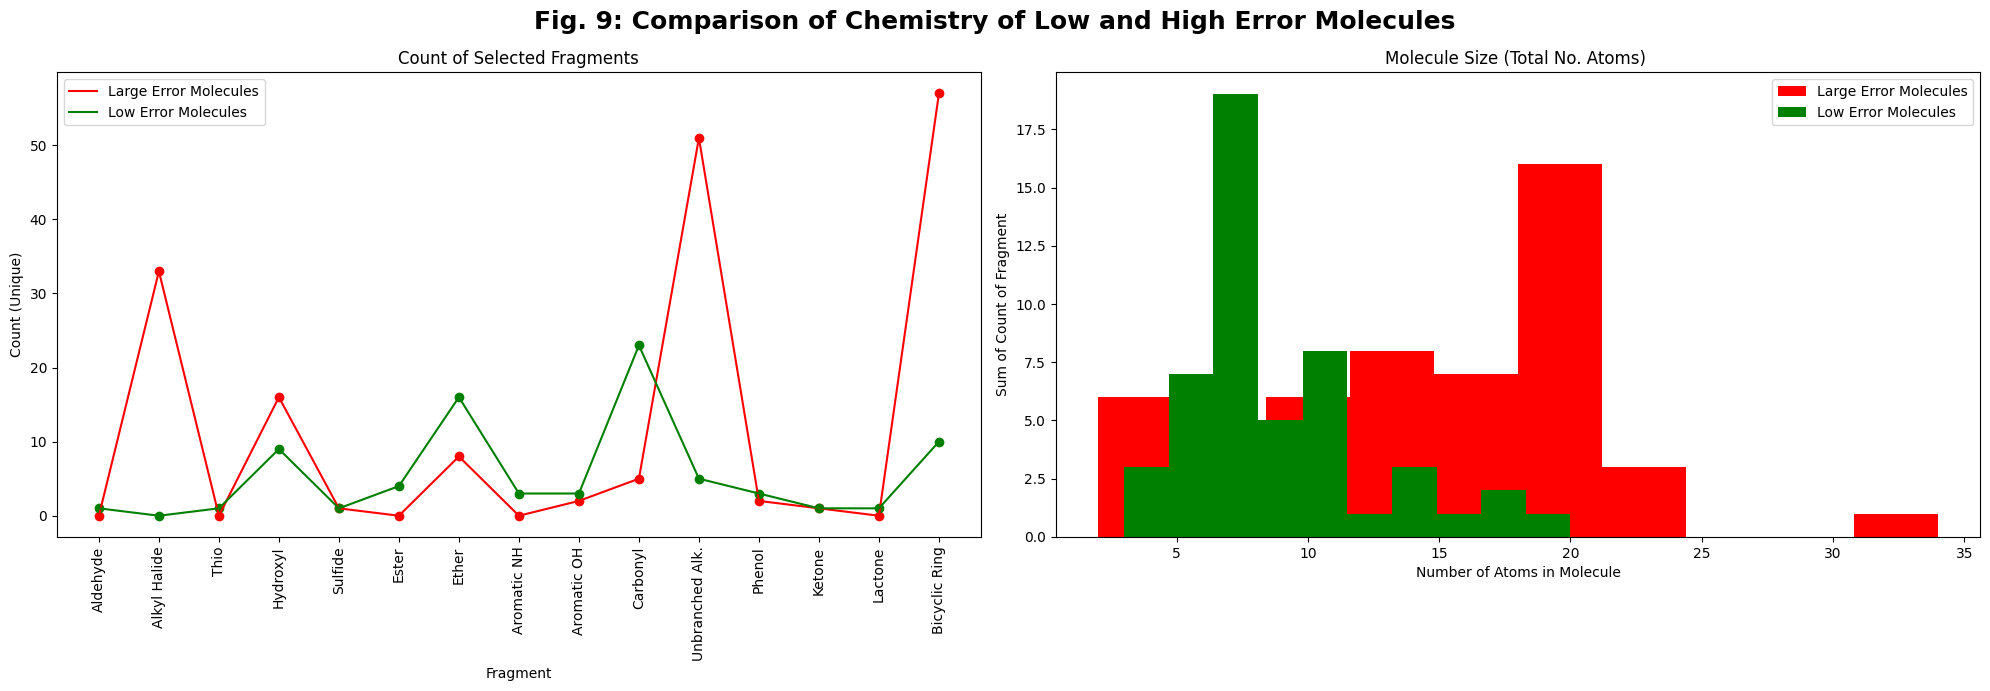

In [ ]:
makefig9()

Finally, in fig. 10 i've plotted the distribution of solubility values for the lowest and highest error molecules respectively. Keep in mind this is an average over 100 random train test splits. It is now very obvious that the large error molecules tend to be very insoluble or very soluble, while the lowest error molecules lie in a narrow span around the mean of the solubility values of the dataset as a whole.

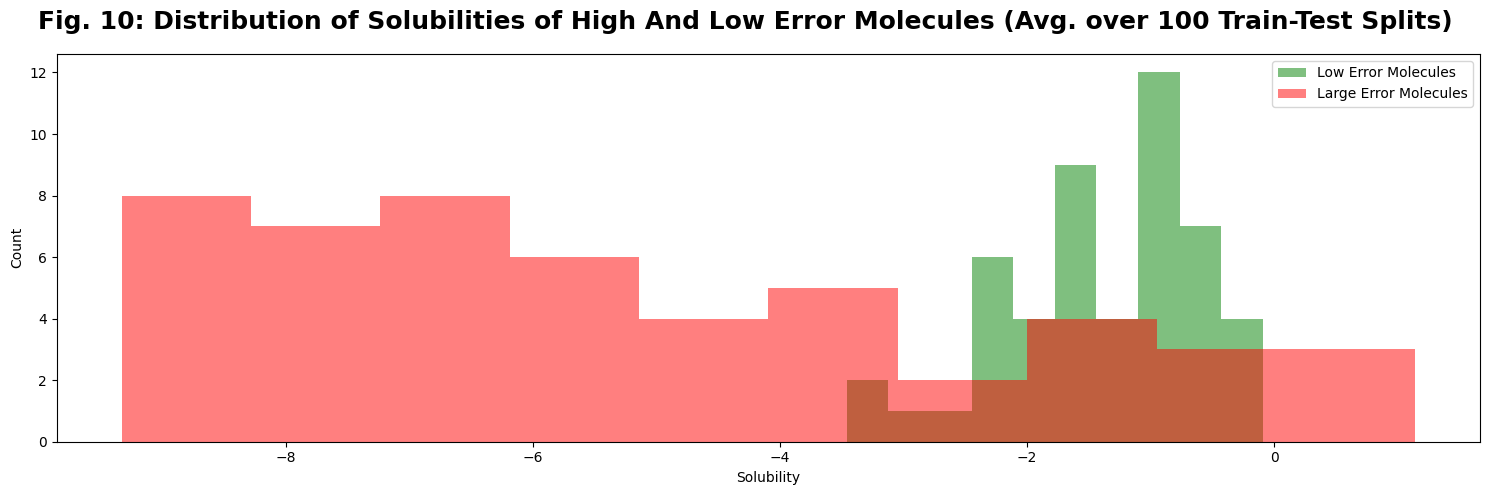

In [ ]:
makefig10()

## **Comparison with Dense Neural Network From The Previous Assigment**
In the previous assignment we also trained a model to predict solubility using a dense neural network trained on the molecular fingerprints of the molecules in the dataset. The table below shows my results from the previous assignment where a dense neural net was trained on morgan fingerprints (Dense) and then the results from the GCN in this assignment. It is clear that the dense neural net got a way better MSE on the train set, but on the test and validation sets the GCN outperforms by a pretty good margin. The GCN also has a much smaller gap between the Train MSE and Test/Val MSE which could be a sign that the GCN is less prone to overfitting.

In [ ]:
results = [{"Train MSE": 0.17, "Test MSE": 1.46, "Val. MSE": 1.36}, {"Train MSE": torch_train_mse, "Test MSE": torch_test_mse, "Val. MSE": torch_val_mse}]
resdf = pd.DataFrame(results, index  = ["Dense", "GCN"])
resdf.style.set_caption("Table 1: Dense Neural Net Trained on FP's vs GCN trained on atom-level features")
resdf

,Train MSE,Test MSE,Val. MSE
Dense,0.17,1.46,1.36
GCN,0.89,0.75,0.89
